# Imports

In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats
import seaborn as sns
import powerlaw
from scipy.stats import poisson
from scipy.stats import norm  
from sklearn.model_selection import train_test_split
import math
import random
from random import shuffle
from scipy.stats import gmean
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
from networkx.algorithms import bipartite
from collections import defaultdict
import itertools

# Custom Functions

In [57]:
def get_all_indices(mylist, myval):
    
    all_indices = []
    
    for i in range(len(mylist)):
        if mylist[i] == myval:
            all_indices.append(i)
            
    return all_indices

def remove_zeros_distribution(x):

    return [i for i in x if i != 0]

def log_binning_distribution(x_i, B = 20): 
    
    x_i = remove_zeros_distribution(x_i)

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))
   
    binned_x_i = []
    density_list = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        count_bin = 0
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                count_bin = count_bin + 1
                
        if count_bin > 0:
            density_bin = count_bin / (len(x_i)*(bin_high-bin_low))
            density_list.append(density_bin)
            binned_x_i.append(bin_low)
        else:
            continue 
            
    return binned_x_i, density_list

# unipartite positive and negative layers ...k01, k10 are column vectors

def multidegree_entropy_pos_neg(k01, k10, precision=10**(-5), loops=10000):
    
    n=len(k01)
    t01=np.random.uniform(size=(n,1))
    t10=np.random.uniform(size=(n,1))
    oldt01=np.random.uniform(size=(n,1))
    oldt10=np.random.uniform(size=(n,1))    
    
    for kk in tqdm(range(loops)):
            T01=t01*(t01.transpose())
            T10=t10*(t10.transpose())
            Z=1+ T01 + T10
            
            #p01
            summat=(np.ones((n,1))*t01.transpose())/(Z+(Z==0))
            summat=summat-np.diag(np.diagonal(summat))
            summat=np.sum(summat,axis=1, keepdims=True);
            t01=k01/(summat+(summat==0))
            T01=t01*(t01.transpose())
            
            Z=1+ T01 + T10
    
            #p10
            summat=(np.ones((n,1))*t10.transpose())/(Z+(Z==0))
            summat=summat-np.diag(np.diagonal(summat))
            summat=np.sum(summat,axis=1,keepdims=True)
            t10=k10/(summat+(summat==0))
            
            #print((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))))
            
            #print(max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0))))))
            
            if np.logical_and((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))< precision),(max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0)))))<precision)):
                break

            oldt01=t01
            oldt10=t10
            
            
    print("Loops ", kk+1)
    print('Error margin: ', max((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))),max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0)))))))
    T01=t01*(t01.transpose());
    T10=t10*(t10.transpose());

    Z=1+ T01 + T10;
    
    
    summat01=T01/(Z+(Z==0))
    summat01=summat01-np.diag(np.diagonal(summat01))
    k01cal=np.sum(summat01,axis=1,keepdims=True);  
    
    summat10=T10/(Z+(Z==0))
    summat10=summat10-np.diag(np.diagonal(summat10))
    k10cal=np.sum(summat10,axis=1,keepdims=True)
                    
    pconditional=summat10/(summat10+summat01+(summat10==0))
    
    return (summat01, k01cal, summat10, k10cal, pconditional)   

    return network_data

def run_configuration_model(network_data, precision=10**(-5), loops=10000):

    ## Create train-test split

    train, test = train_test_split(network_data, test_size=0.3)

    train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
    train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

    degree_train_1_0 = []
    degree_train_0_1 = []

    for node in tqdm(train_nodes):
        sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
        degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
        degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
    ## Degree ratio distirbution

    degree_ratio_list = [degree_train_1_0[i]/(degree_train_1_0[i] + degree_train_0_1[i]) for i in range(len(train_nodes))]

    figure(figsize=(8, 8),dpi=300)
    ax = sns.histplot(degree_ratio_list, stat='density', linewidth=0)
    ax.set(xlim = [0,1], xlabel=r'$\rho$', ylabel='PDF')
    plt.savefig('No-fluctuations-degree-ratio.svg', format='svg')
    plt.show()
                
    df = pd.DataFrame()
    df['degree_ratio'] = [float(x) for x in degree_ratio_list]
    df.to_csv('No-fluctuations-degree-ratio.csv', float_format='%g') 

    sum_degree =  [a + b for a,b in zip(degree_train_1_0,degree_train_0_1)]
    print('Number of nodes with not positive or negative annotation: ', sum_degree.count(0))

    print('Validating p_bind value from binary labels: ', network_data['binary_label'].tolist().count(1) / len(network_data))

    summat01, k01cal, summat10, k10cal, pconditional = multidegree_entropy_pos_neg(np.array([degree_train_0_1]).T, np.array([degree_train_1_0]).T, precision=precision, loops=loops)

    test_probabilty_predicted_conditioned = []
    test_type_list = []

    ## Average conditional probability
    
    p10_avg = np.mean(summat10)
    p01_avg = np.mean(summat01)
    average_conditional_probability = p10_avg / (p10_avg + p01_avg)

    for index, row in tqdm(test.iterrows()):      
    
        if row['node_1'] in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]
            p10_conditioned = pconditional[mapped_index_in_matrix_node_1, mapped_index_in_matrix_node_2]
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Transductive')
        
        elif row['node_1'] in train_nodes and row['node_2'] not in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]
            p10_conditioned = degree_train_1_0[mapped_index_in_matrix_node_1] / (degree_train_0_1[mapped_index_in_matrix_node_1] + degree_train_1_0[mapped_index_in_matrix_node_1] ) ## k_+ / (k_+ + k_-)
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Semi-inductive')
        
        elif row['node_1'] not in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]
            p10_conditioned = degree_train_1_0[mapped_index_in_matrix_node_2] / (degree_train_0_1[mapped_index_in_matrix_node_2] + degree_train_1_0[mapped_index_in_matrix_node_2] ) ## k_+ / (k_+ + k_-)
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Semi-inductive')
        
        else:
            p10_conditioned = average_conditional_probability
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Inductive')
        
    test_predictions = test.copy()
    test_predictions['predicted_probability'] = test_probabilty_predicted_conditioned
    test_predictions['test_type'] = test_type_list

    ## Performance on the test dataset

    print('AUC: ', roc_auc_score(test_predictions['binary_label'].tolist(), test_predictions['predicted_probability'].tolist()))
    print('AUP: ', average_precision_score(test_predictions['binary_label'].tolist(), test_predictions['predicted_probability'].tolist()))

    print('Transductive performance:')

    test_predictions_transductive = test_predictions[test_predictions['test_type'] == 'Transductive']
    print('AUC: ', roc_auc_score(test_predictions_transductive['binary_label'].tolist(), test_predictions_transductive['predicted_probability'].tolist()))
    print('AUP: ', average_precision_score(test_predictions_transductive['binary_label'].tolist(), test_predictions_transductive['predicted_probability'].tolist()))

    figure(figsize=(8, 8),dpi=300)
    ax = sns.histplot(test_predictions['predicted_probability'].tolist(), stat='density', linewidth=0)
    ax.set(xlim = [0,1], xlabel='$p^{conditional}$', ylabel='PDF')
    plt.savefig("No-fluctuations-conditional-probability.svg", format="svg")
    plt.show()
                
    df = pd.DataFrame()
    df['conditional_probability'] = test_predictions_transductive['predicted_probability'].tolist()
    df.to_csv('No-fluctuations-conditional-probability.csv') 
    
    return

def sampling_with_corrP(kvec, corrc, mean_log_Kd, std_log_Kd, kd_list, p_bind = 0.16, iterl=5000): ## P for Poisson
    
    avgk=np.mean(kvec)
    ecdfK =ECDF(kvec)
    x=ecdfK.x[1:]
    y=ecdfK.y[1:]
    MAT_k=np.array([x, y, poisson.ppf(y, avgk)]).T
    MAT_k[-1,2]=poisson.ppf((MAT_k.shape[0]-0.5)/MAT_k.shape[0], avgk)
    
    Gpoisson= nx.configuration_model(MAT_k[:,2].astype(int),create_using=nx.Graph(), seed=None)
    Gpoisson.remove_edges_from(nx.selfloop_edges(Gpoisson))  
    
    degrees_from_network = [Gpoisson.degree(node) for node in list(Gpoisson.nodes())]
    cdfk=[poisson.cdf(x, np.mean(degrees_from_network)) for x in degrees_from_network]
    MAT=np.array([degrees_from_network, cdfk, norm.ppf(cdfk, loc=0, scale=1)]).T
    expMU=mean_log_Kd+corrc*std_log_Kd*MAT[:,2]
    expSIGMA=np.sqrt((1-corrc**2)*(std_log_Kd**2))
    
    ###############################################################################################################
    ############################ ALL NODES WITH THE SAME DEGREE HAS SAME KD #######################################
    
    k_l = list(MAT[:,0].astype(int))
    unique_kl = list(set(k_l))
    k_mu_sigma_unique = []
    expMU_list = list(expMU)

    for k in tqdm(unique_kl):
        val_ind = get_all_indices(k_l,k)
        expMU_temp = []
        for j in val_ind:
            expMU_temp.append(expMU_list[j])
        mean_expMU = np.mean(expMU_temp)
        k_mu_sigma_unique = k_mu_sigma_unique + [mean_expMU] * len(val_ind)
    
    ###############################################################################################################
    
    random_Kd_dict = dict()
    node_degree_list = []
    degree_Kd_list_list = []
    degree_log_Kd_list_list = []

    for node in tqdm(list(Gpoisson.nodes())):
        random_Kd_dict[node] = [k_mu_sigma_unique[node]]
        node_degree_list.append(Gpoisson.degree(node))
        degree_Kd_list_list.append([k_mu_sigma_unique[node]]) 
        degree_log_Kd_list_list.append(list(np.log([k_mu_sigma_unique[node]])))
        
    different_protein_annotations = list(set(node_degree_list))
    unique_Kd_proteins = []
    unique_Kd_proteins_std = []
    unique_log_Kd_proteins = []
    unique_log_Kd_proteins_std = []
    sample_size_list = []

    for unique_ann in tqdm(different_protein_annotations):
    
        all_Kd_list = []   
        all_log_Kd_list = []  
        all_indices = get_all_indices(node_degree_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list = all_Kd_list + degree_Kd_list_list[j]
            all_log_Kd_list = all_log_Kd_list + degree_log_Kd_list_list[j]
        
        unique_Kd_proteins.append(np.mean(all_Kd_list))
        unique_Kd_proteins_std.append(np.std(all_Kd_list))
        unique_log_Kd_proteins.append(np.mean(all_log_Kd_list))
        unique_log_Kd_proteins_std.append(np.std(all_log_Kd_list))
        sample_size_list.append(len(all_log_Kd_list))

    figure(figsize=(8, 8),dpi=300)
    plt.errorbar(different_protein_annotations, unique_Kd_proteins, yerr=unique_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.yscale('log')
    plt.savefig("No-fluctuations-corrP-annotations-Kd.svg", format="svg")
    plt.show()
                
    df = pd.DataFrame()
    df['different_protein_annotations'] = different_protein_annotations
    df['unique_Kd_proteins'] = unique_Kd_proteins
    df['unique_Kd_proteins_std'] = unique_Kd_proteins_std
    df['sample_size'] = sample_size_list
    df.to_csv('No-fluctuations-corrP-annotations-Kd.csv') 
        
    figure(figsize=(8, 8),dpi=300)
    plt.errorbar(different_protein_annotations, unique_log_Kd_proteins, yerr=unique_log_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.savefig("No-fluctuations-corrP-annotations-logKd.svg", format="svg")
    plt.show()
                
    df = pd.DataFrame()
    df['different_protein_annotations'] = different_protein_annotations
    df['unique_log_Kd_proteins'] = unique_log_Kd_proteins
    df['unique_log_Kd_proteins_std'] = unique_log_Kd_proteins_std
    df['sample_size'] = sample_size_list
    df.to_csv('No-fluctuations-corrP-annotations-logKd.csv') 
    
    node_list_1 = []
    node_list_2 = []
    node_Kd_list_1 = []
    node_Kd_list_2 = []
    
    for edge in tqdm(list(Gpoisson.edges())):
        node_list_1.append(edge[0])
        node_list_2.append(edge[1])
        node_Kd_list_1.append(np.random.choice(random_Kd_dict[edge[0]])) ## Have fluctuations by randomly selecting from 5000 Kd points
        node_Kd_list_2.append(np.random.choice(random_Kd_dict[edge[1]]))
    
    network_data = pd.DataFrame()
    network_data['node_1'] = node_list_1
    network_data['node_2'] = node_list_2
    network_data['node_1_Kd'] = node_Kd_list_1
    network_data['node_2_Kd'] = node_Kd_list_2
    network_data['edge_Kd'] = [np.sqrt(a*b) for a,b in zip(node_Kd_list_1,node_Kd_list_2)]
    
    ## Making binary labels with p_bind

    Kd_for_edges = network_data['edge_Kd'].tolist()
    threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))

    print('Threshold: ', threshold) ## in nM

    binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]

    network_data['binary_label'] = binary_labels
    
    return network_data, node_degree_list

def sampling_with_corr(kvec, corrc, mean_log_Kd, std_log_Kd, kd_list, p_bind = 0.16, iterl=5000):

    avgk=np.mean(kvec)
    ecdfK =ECDF(kvec)
    MAT=np.array([ecdfK.x, ecdfK.y, norm.ppf(ecdfK.y, loc=0, scale=1)]).T
    MAT=MAT[1:,:]
    MAT[-1,2]=norm.ppf((MAT.shape[0]-0.5)/MAT.shape[0], loc=0, scale=1)
    expMU=mean_log_Kd+corrc*std_log_Kd*MAT[:,2]
    expSIGMA=np.sqrt((1-corrc**2)*(std_log_Kd**2))
    
    # fat-tailed network
    G= nx.configuration_model(MAT[:,0].astype(int), create_using=nx.Graph(), seed=None)
    G.remove_edges_from(nx.selfloop_edges(G))
    
    ###############################################################################################################
    ############################ ALL NODES WITH THE SAME DEGREE HAS SAME KD #######################################
    
    k_l = list(MAT[:,0].astype(int))
    unique_kl = list(set(k_l))
    k_mu_sigma_unique = []
    expMU_list = list(expMU)
    #expSIGMA_list = list(expSIGMA)

    for k in tqdm(unique_kl):
        val_ind = get_all_indices(k_l,k)
        expMU_temp = []
        expSIGMA_temp = []
        for j in val_ind:
            expMU_temp.append(expMU_list[j])
        mean_expMU = np.mean(expMU_temp)
        k_mu_sigma_unique = k_mu_sigma_unique + [mean_expMU] * len(val_ind)
    
    ###############################################################################################################
        
    random_Kd_dict = dict()
    node_degree_list = []
    degree_Kd_list_list = []
    degree_log_Kd_list_list = []

    for node in tqdm(list(G.nodes())):
        random_Kd_dict[node] = [k_mu_sigma_unique[node]]
        node_degree_list.append(G.degree(node))
        degree_Kd_list_list.append([k_mu_sigma_unique[node]]) 
        degree_log_Kd_list_list.append(list(np.log([k_mu_sigma_unique[node]])))
        
    different_protein_annotations = list(set(node_degree_list))
    unique_Kd_proteins = []
    unique_Kd_proteins_std = []
    unique_log_Kd_proteins = []
    unique_log_Kd_proteins_std = []
    sample_size_list = []

    for unique_ann in tqdm(different_protein_annotations):
    
        all_Kd_list = []   
        all_log_Kd_list = []  
        all_indices = get_all_indices(node_degree_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list = all_Kd_list + degree_Kd_list_list[j]
            all_log_Kd_list = all_log_Kd_list + degree_log_Kd_list_list[j]
        
        unique_Kd_proteins.append(np.mean(all_Kd_list))
        unique_Kd_proteins_std.append(np.std(all_Kd_list))
        unique_log_Kd_proteins.append(np.mean(all_log_Kd_list))
        unique_log_Kd_proteins_std.append(np.std(all_log_Kd_list))
        sample_size_list.append(len(all_log_Kd_list))

    figure(figsize=(8, 8),dpi=300)
    plt.errorbar(different_protein_annotations, unique_Kd_proteins, yerr=unique_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([10**(-20),10**(11)])
    plt.savefig("No-fluctuations-corr-protein-annotations-Kd.svg", format="svg")
    plt.show()
    print('Correlation between k and <Kd> at edge level: ', stats.spearmanr(different_protein_annotations, unique_Kd_proteins))
    
                
    df = pd.DataFrame()
    df['different_protein_annotations'] = different_protein_annotations
    df['unique_Kd_proteins'] = unique_Kd_proteins
    df['unique_Kd_proteins_std'] = unique_Kd_proteins_std
    df['sample_size'] = sample_size_list
    df.to_csv('No-fluctuations-corr-protein-annotations-Kd.csv') 
        
    figure(figsize=(8, 8),dpi=300)
    plt.errorbar(different_protein_annotations, unique_log_Kd_proteins, yerr=unique_log_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.ylim([0,14])
    plt.savefig("No-fluctuations-corr-protein-annotations-logKd.svg", format="svg")
    plt.show()
                
    df = pd.DataFrame()
    df['different_protein_annotations'] = different_protein_annotations
    df['unique_log_Kd_proteins'] = unique_log_Kd_proteins
    df['unique_log_Kd_proteins_std'] = unique_log_Kd_proteins_std
    df['sample_size'] = sample_size_list
    df.to_csv('No-fluctuations-corr-protein-annotations-logKd.csv') 

    node_list_1 = []
    node_list_2 = []
    node_Kd_list_1 = []
    node_Kd_list_2 = []
    
    for edge in tqdm(list(G.edges())):
        node_list_1.append(edge[0])
        node_list_2.append(edge[1])
        node_Kd_list_1.append(np.random.choice(random_Kd_dict[edge[0]]))
        node_Kd_list_2.append(np.random.choice(random_Kd_dict[edge[1]]))
    
    network_data = pd.DataFrame()
    network_data['node_1'] = node_list_1
    network_data['node_2'] = node_list_2
    network_data['node_1_Kd'] = node_Kd_list_1
    network_data['node_2_Kd'] = node_Kd_list_2
    network_data['edge_Kd'] = [np.sqrt(a*b) for a,b in zip(node_Kd_list_1,node_Kd_list_2)]

    ## Making binary labels with p_bind

    Kd_for_edges = network_data['edge_Kd'].tolist()
    threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))

    print('Threshold: ', threshold) ## in nM

    binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]

    network_data['binary_label'] = binary_labels
    
    return network_data, node_degree_list

def remove_correlation_run_configuration_model(network_data, precision=10**(-5), loops=10000):
    
    c = list(zip(network_data['edge_Kd'].tolist(), network_data['binary_label'].tolist()))
    random.shuffle(c)
    shuffled_edge_Kd, shuffled_binary_label = zip(*c)
    
    network_data_shuffled = network_data.copy()
    network_data_shuffled['edge_Kd'] = shuffled_edge_Kd
    network_data_shuffled['binary_label'] = shuffled_binary_label
    
    nodes = list(set(network_data_shuffled['node_1']).union(set(network_data_shuffled['node_2'])))

    K_from_copula_list = []
    Kd_from_copula_list = []

    for node in tqdm(nodes):
        sub_df = network_data_shuffled[(network_data_shuffled['node_1'] == node) | (network_data_shuffled['node_2'] == node)]
        K_from_copula_list.append(len(sub_df))
        Kd_from_copula_list.append(sub_df['edge_Kd'].tolist())

    different_target_annotations_copula = list(set(K_from_copula_list))
    unique_Kd_proteins = []
    unique_Kd_proteins_std = []
    unique_log_Kd_proteins = []
    unique_log_Kd_proteins_std = []
    sample_size_list = []
    
    for unique_ann in tqdm(different_target_annotations_copula):
    
        all_Kd_list = []    
        all_log_Kd_list = []   
        all_indices = get_all_indices(K_from_copula_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list = all_Kd_list + Kd_from_copula_list[j]
            all_log_Kd_list = all_log_Kd_list + list(np.log(Kd_from_copula_list[j]))
        
        unique_Kd_proteins.append(np.mean(all_Kd_list))
        unique_Kd_proteins_std.append(np.std(all_Kd_list))
        unique_log_Kd_proteins.append(np.mean(all_log_Kd_list))
        unique_log_Kd_proteins_std.append(np.std(all_log_Kd_list))
        sample_size_list.append(len(all_log_Kd_list))
        
    print('Correlation between k and <Kd> at edge level: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_proteins))
    
    figure(figsize=(8, 8),dpi=300)
    plt.errorbar(different_target_annotations_copula, unique_Kd_proteins, yerr=unique_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
                        
    figure(figsize=(8, 8),dpi=300)
    plt.errorbar(different_target_annotations_copula, unique_log_Kd_proteins, yerr=unique_log_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.show()

    run_configuration_model(network_data_shuffled, precision=precision, loops=loops)
    
    return network_data_shuffled


# Loading and analysing BindingDB

In [5]:
df = pd.read_csv('../../BindingDB_All.tsv', sep = '\t', error_bad_lines=False)
df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1.0]
df = df[df['Ligand SMILES'].notnull()]

idx_str = 'Kd (nM)'

df_want = df[df[idx_str].notnull()]
df_want = df_want[['BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand SMILES',\
                    'PubChem CID', 'UniProt (SwissProt) Primary ID of Target Chain',\
                    'BindingDB Target Chain  Sequence', idx_str]]

df_want.rename(columns={'BindingDB Reactant_set_id':'ID', 'Ligand SMILES':'SMILES',\
                        'Ligand InChI':'InChI', 'PubChem CID':'PubChem_ID',
                        'UniProt (SwissProt) Primary ID of Target Chain':'UniProt_ID',
                        'BindingDB Target Chain  Sequence': 'Target Sequence',
                            idx_str: 'Label'}, inplace=True)

df_want['Label'] = df_want['Label'].str.replace('>', '')
df_want['Label'] = df_want['Label'].str.replace('<', '')
df_want['Label'] = df_want['Label'].astype(float)

# have at least uniprot or pubchem ID
df_want = df_want[df_want.PubChem_ID.notnull() | df_want.UniProt_ID.notnull()]
df_want = df_want[df_want.InChI.notnull()]

df_want = df_want[(df_want.Label <= 10000000.0) & (df_want.Label != 0)]
#remove zeros
df_want=df_want[df_want['Label']>0]
print('There are ' + str(len(df_want)) + ' drug target pairs.')


b'Skipping line 896772: expected 193 fields, saw 205\nSkipping line 896798: expected 193 fields, saw 205\n'
b'Skipping line 929491: expected 193 fields, saw 205\n'
b'Skipping line 952161: expected 193 fields, saw 265\n'
b'Skipping line 1355895: expected 193 fields, saw 241\n'
b'Skipping line 1469800: expected 193 fields, saw 241\nSkipping line 1469801: expected 193 fields, saw 241\nSkipping line 1469802: expected 193 fields, saw 241\nSkipping line 1469803: expected 193 fields, saw 241\nSkipping line 1469804: expected 193 fields, saw 241\nSkipping line 1469805: expected 193 fields, saw 241\nSkipping line 1469806: expected 193 fields, saw 241\nSkipping line 1469807: expected 193 fields, saw 241\nSkipping line 1469808: expected 193 fields, saw 241\n'
b'Skipping line 1483073: expected 193 fields, saw 205\n'
b'Skipping line 1502296: expected 193 fields, saw 241\nSkipping line 1502297: expected 193 fields, saw 241\nSkipping line 1502298: expected 193 fields, saw 241\nSkipping line 1502299: e

There are 70746 drug target pairs.


In [6]:
df_want_Kd = df_want[['SMILES','Target Sequence','Label']]

threshold = 30 ## DeepPurpose threshold in nM

df_want_Kd_binary = df_want_Kd.copy()
df_want_Kd_binary['Label'] = [1 if x < threshold else 0 for x in tqdm(df_want_Kd['Label'].tolist())]

ligands = list(set(df_want_Kd_binary['SMILES'].tolist()))
targets = list(set(df_want_Kd_binary['Target Sequence'].tolist()))

target_annotations_bindingDB = []

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations_bindingDB.append(len(sub_df))
    
print('Average annotations for proteins: ', np.mean(target_annotations_bindingDB))

100%|█████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:11<00:00, 129.24it/s]

Average annotations for proteins:  46.94492368944924


In [7]:
df_want_Kd_binary['Constant']=df_want_Kd['Label']
df_want_Kd_binary['Constant_log']=df_want_Kd_binary['Constant'].apply(np.log)
meanlog_constant=df_want_Kd_binary['Constant_log'].mean()
stdlog_constant=df_want_Kd_binary['Constant_log'].std()
df_want_Kd_binary=df_want_Kd_binary.sort_values(by=['Constant'])
print(df_want_Kd_binary['Constant_log'].mean())
print(df_want_Kd_binary['Constant_log'].std())

ecdfkr =ECDF(df_want_Kd_binary['Constant_log'])
MAT=np.array([ecdfkr.x, ecdfkr.y, norm.ppf(ecdfkr.y, loc=meanlog_constant, scale=stdlog_constant)]).T
MAT=MAT[1:,:]
MAT[-1,2]=norm.ppf((MAT.shape[0]-0.5)/MAT.shape[0], loc=meanlog_constant, scale=stdlog_constant)
df_want_Kd_binary['Constant_lognormal']=MAT[:,2]
df_want_Kd_binary['Constant_transformed']=np.exp(df_want_Kd_binary['Constant_lognormal'])

7.1043771550585095
3.333684955402517


In [8]:
print(max(df_want_Kd_binary['Constant_log'][df_want_Kd_binary['Label']==1]))
print(max(df_want_Kd_binary['Constant_lognormal'][df_want_Kd_binary['Label']==1]))

Tlog=max(df_want_Kd_binary['Constant_lognormal'][df_want_Kd_binary['Label']==1])
df_want_Kd_binary['Labelcheck']=[1 if x < Tlog else 0 for x in tqdm(df_want_Kd_binary['Constant_lognormal'].tolist())]

3.3847291889548483
3.8093724849192903


100%|███████████████████████████████████████████████████████████████████████| 70746/70746 [00:00<00:00, 2021240.49it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:21<00:00, 70.25it/s]
C:\Users\Ayan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0, 0.5, 'pdf'), Text(0.5, 0, 'log Kd')]

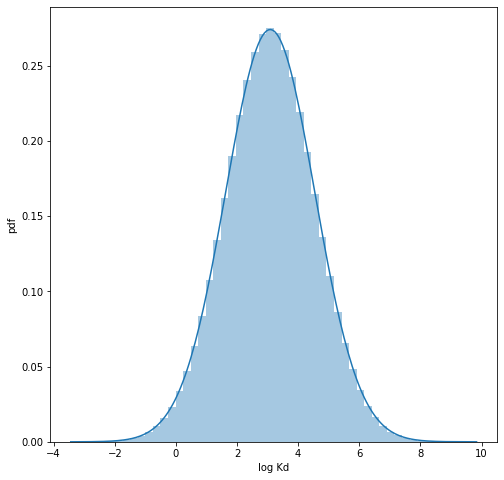

In [9]:
#tomonitor='Label'
tomonitor='Labelcheck'

#selectconstant='Constant'
selectconstant='Constant_transformed'

dictchem_kplus={}
dictchem_kminus={}
for chem in tqdm(ligands):
    dictchem_kplus[chem]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['SMILES']==chem]==1)
    dictchem_kminus[chem]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['SMILES']==chem]==0)
    
dictchem_k={chem:(dictchem_kplus[chem]+dictchem_kminus[chem]) for chem in ligands}
dictchem_ratio={chem:dictchem_kplus[chem]/dictchem_k[chem] for chem in ligands}

dicttarget_kplus={}
dicttarget_kminus={}
for t in tqdm(targets):
    dicttarget_kplus[t]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['Target Sequence']==t]==1)
    dicttarget_kminus[t]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['Target Sequence']==t]==0)
    
dicttarget_k={t:(dicttarget_kplus[t]+dicttarget_kminus[t]) for t in targets}
dicttarget_ratio={t:dicttarget_kplus[t]/dicttarget_k[t] for t in targets}

df_want_Kd_binary['k_l']=[dictchem_k[c] for c in df_want_Kd_binary['SMILES']]
df_want_Kd_binary['k_t']=[dicttarget_k[t] for t in df_want_Kd_binary['Target Sequence']]

kd_list = list(df_want_Kd_binary[selectconstant])
figure(figsize=(8, 8))
ax = sns.distplot(np.log10(kd_list), norm_hist=True)
ax.set(xlabel='log Kd', ylabel='pdf')

In [10]:
# this values are per link
mean_log_Kd = np.mean(np.log(kd_list))
std_log_Kd = np.std(np.log(kd_list))

print('Mean and standard deviation of log Kd: ', mean_log_Kd, std_log_Kd)

Mean and standard deviation of log Kd:  7.1045817466220855 3.33363334105165


## Generating the network

In [11]:
THR = 0.16 # p_bind threshold
anti_corr = -0.47 ## Same as original BindingDB data
iterl=1 ## Without fluctuations

In [12]:
kvec=sorted(target_annotations_bindingDB)

# Power-law with correlation

100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 4102.06it/s]


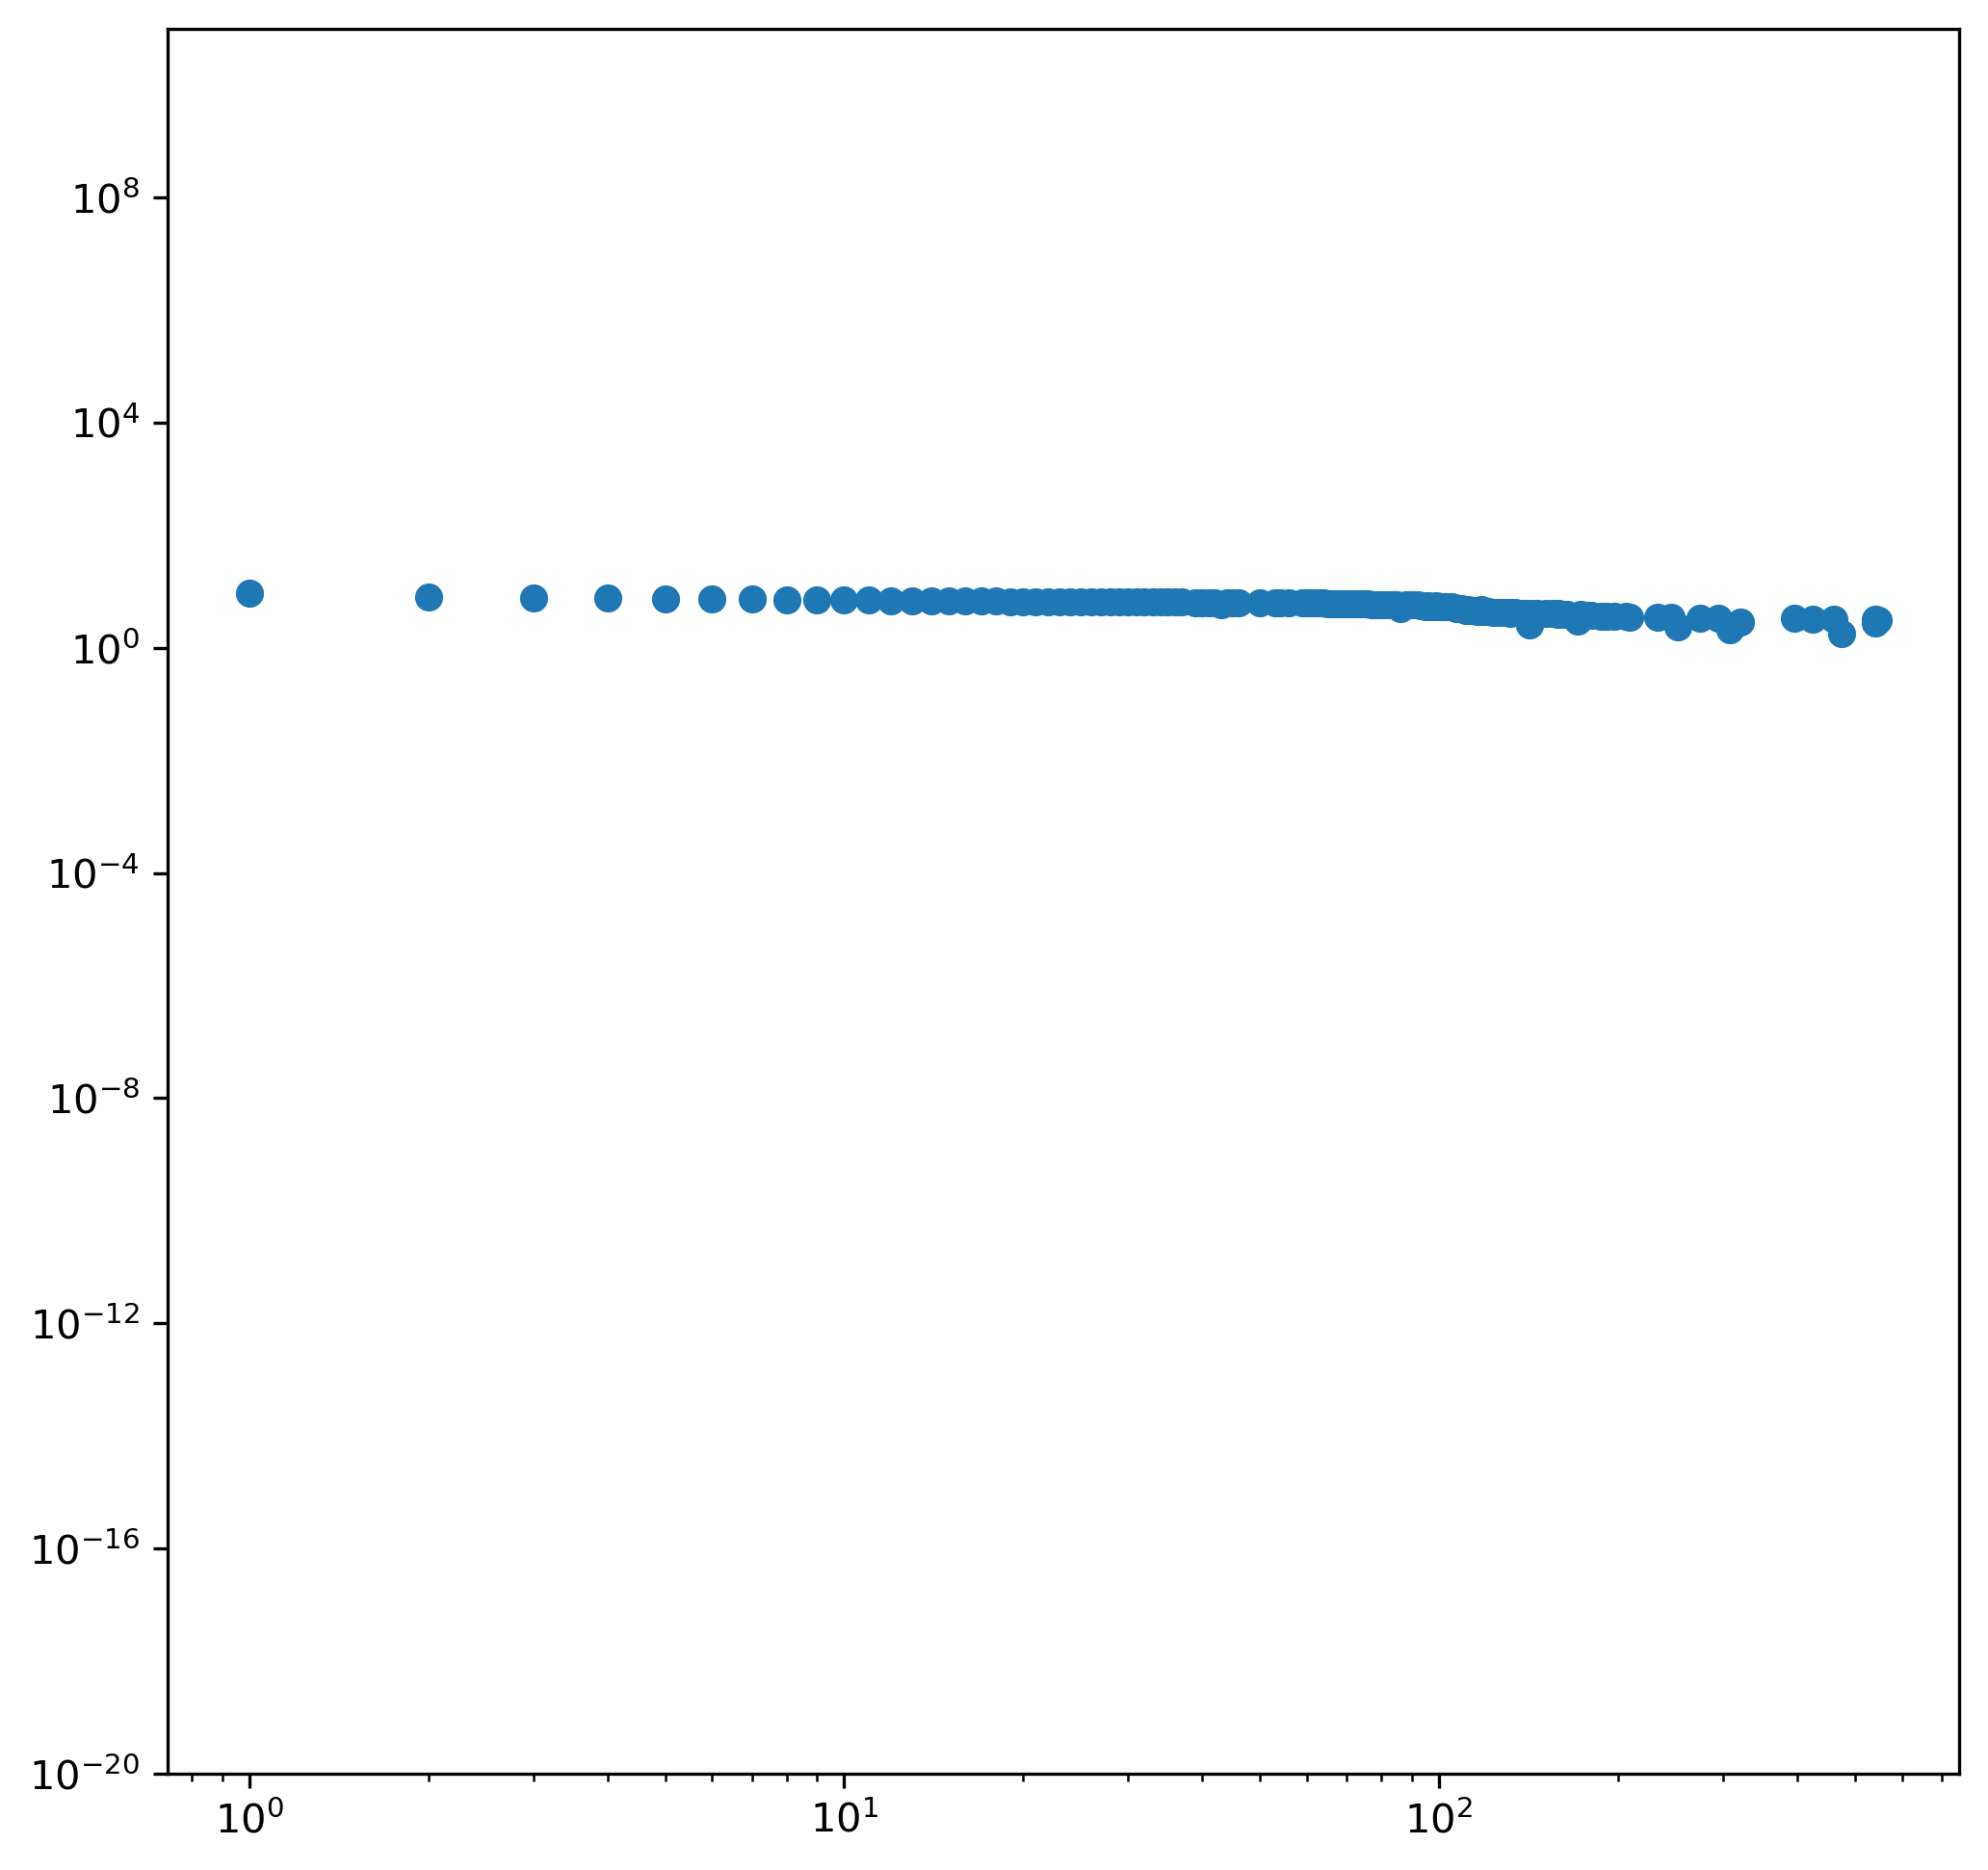

Correlation between k and <Kd> at edge level:  SpearmanrResult(correlation=-0.9935515277239115, pvalue=1.6208369506637133e-147)


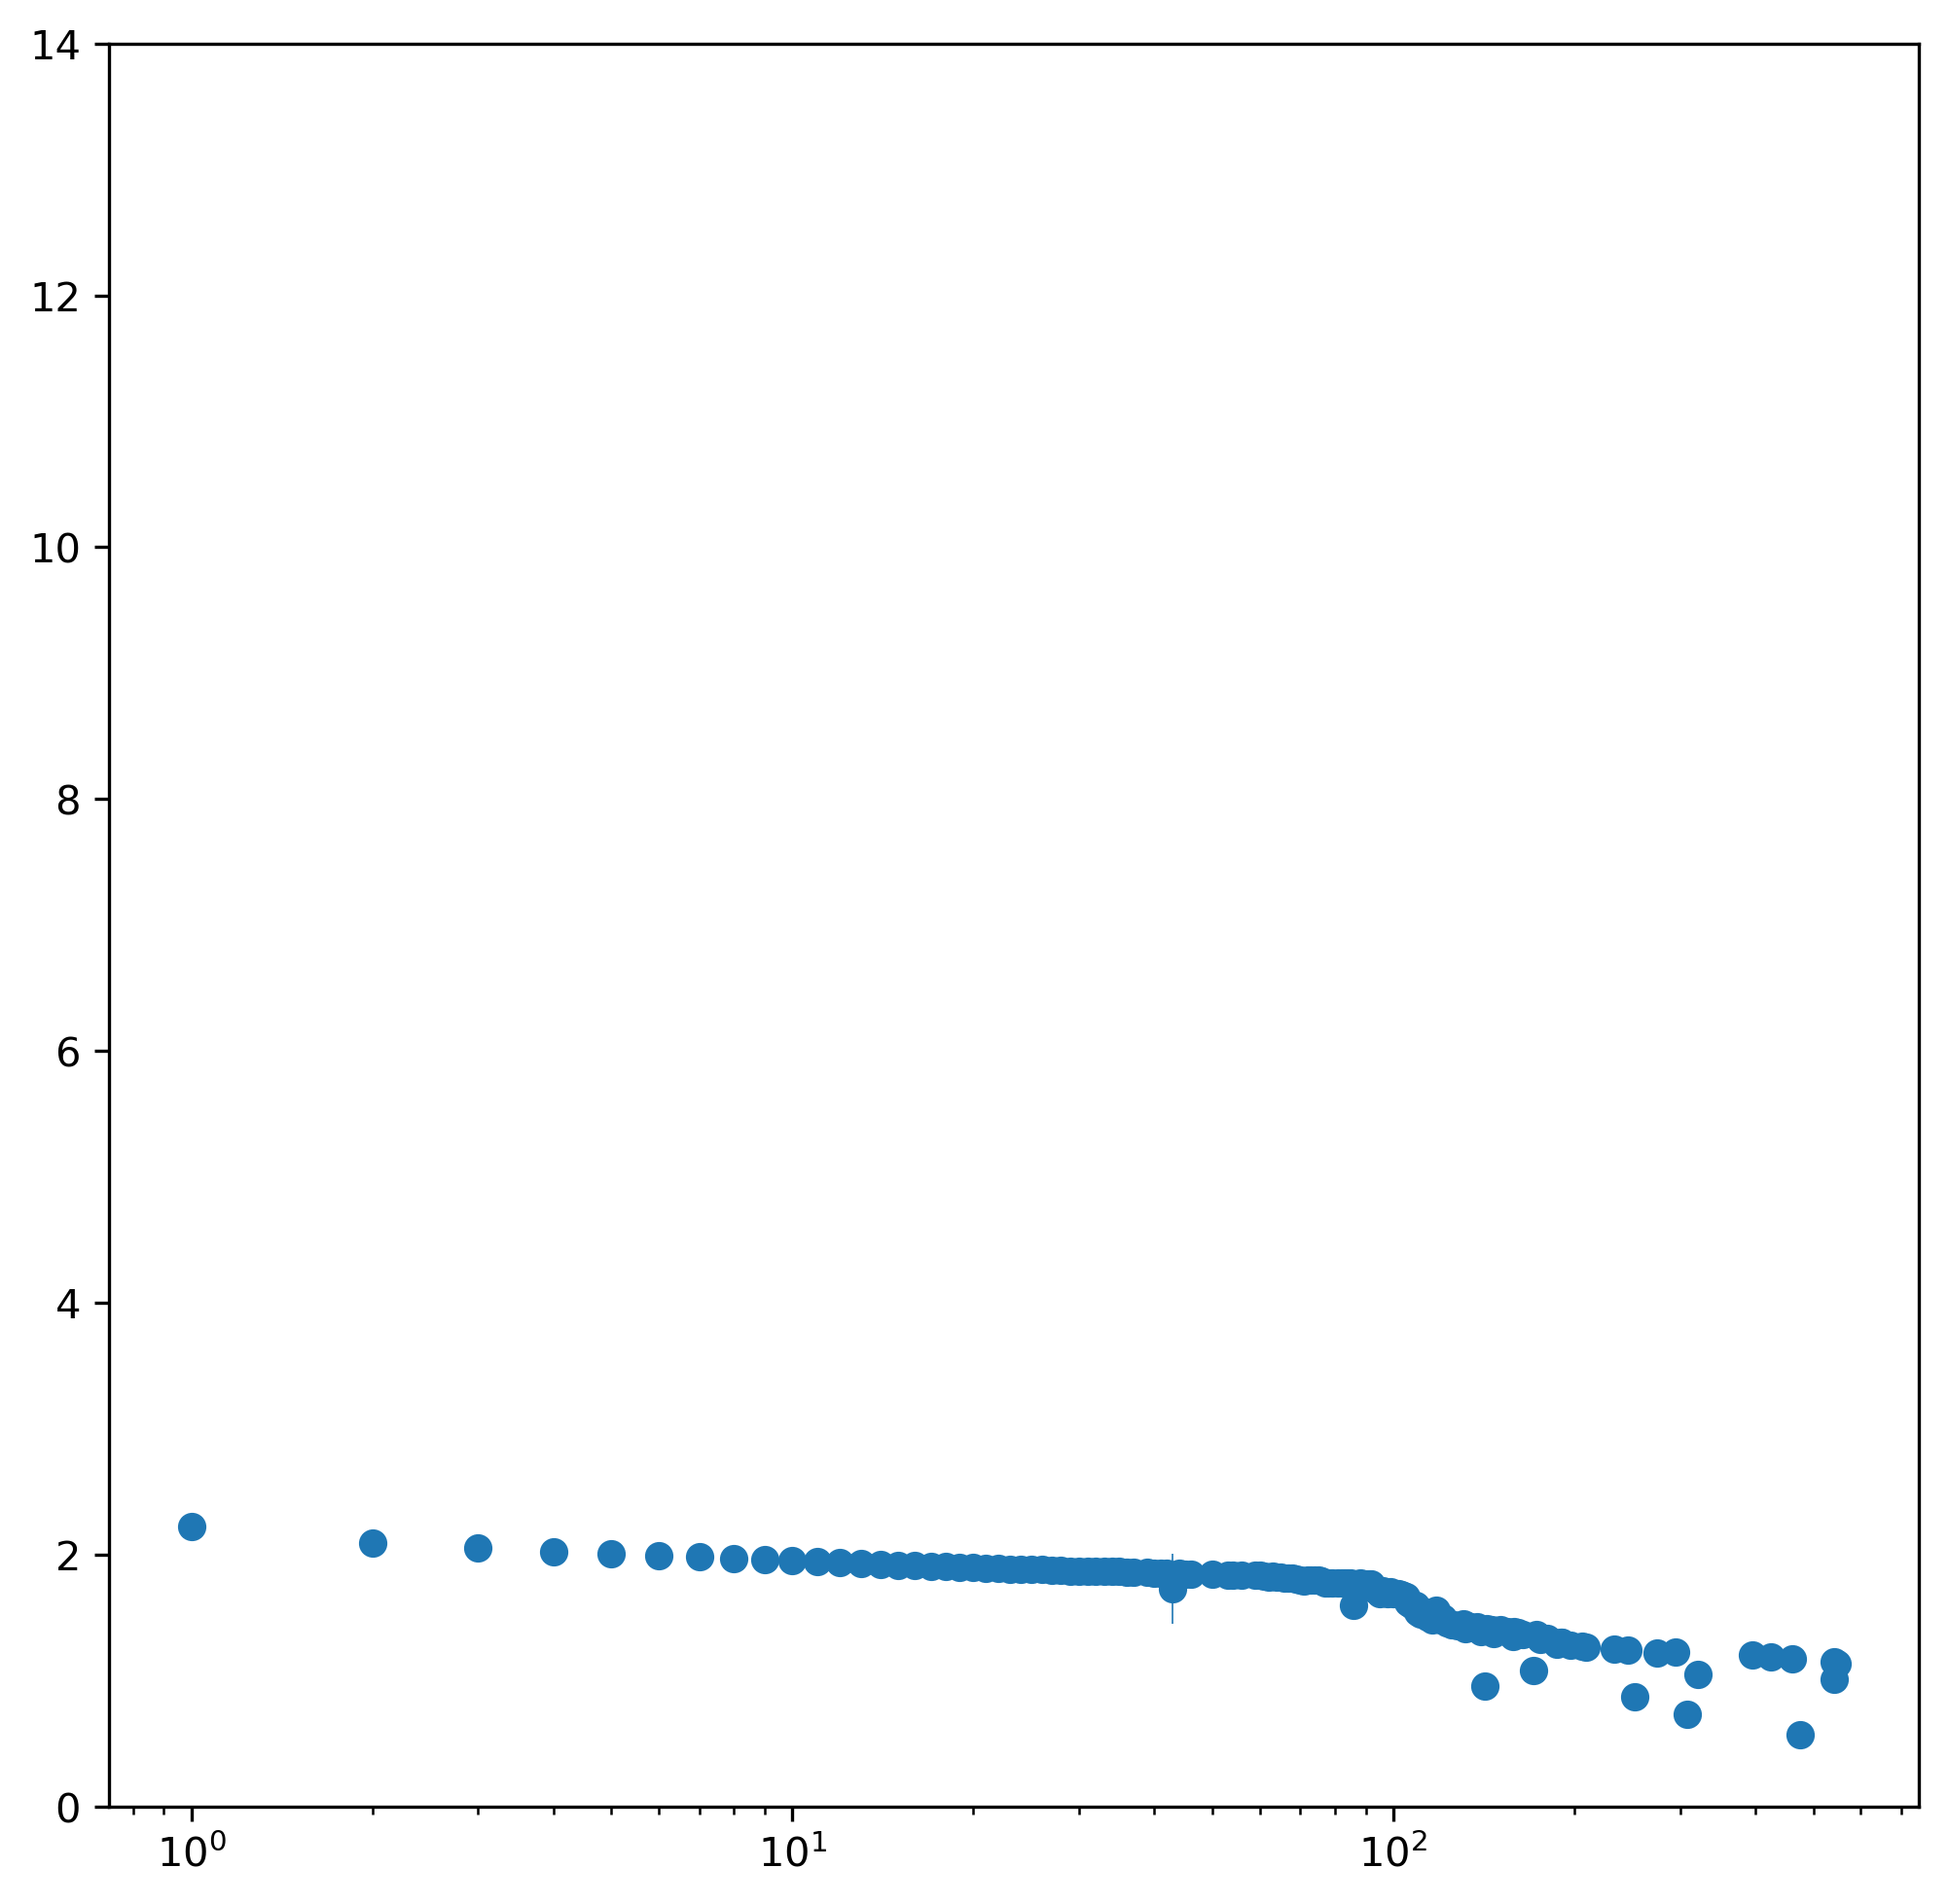

100%|█████████████████████████████████████████████████████████████████████████| 28579/28579 [00:01<00:00, 23735.95it/s]


Threshold:  4.285423337274856


In [58]:
network_data_BC, node_degree_list = sampling_with_corr(kvec, anti_corr, mean_log_Kd, std_log_Kd, kd_list, p_bind = THR, iterl=1)

100%|█████████████████████████████████████████████████████████████████████████████| 1388/1388 [00:03<00:00, 437.30it/s]


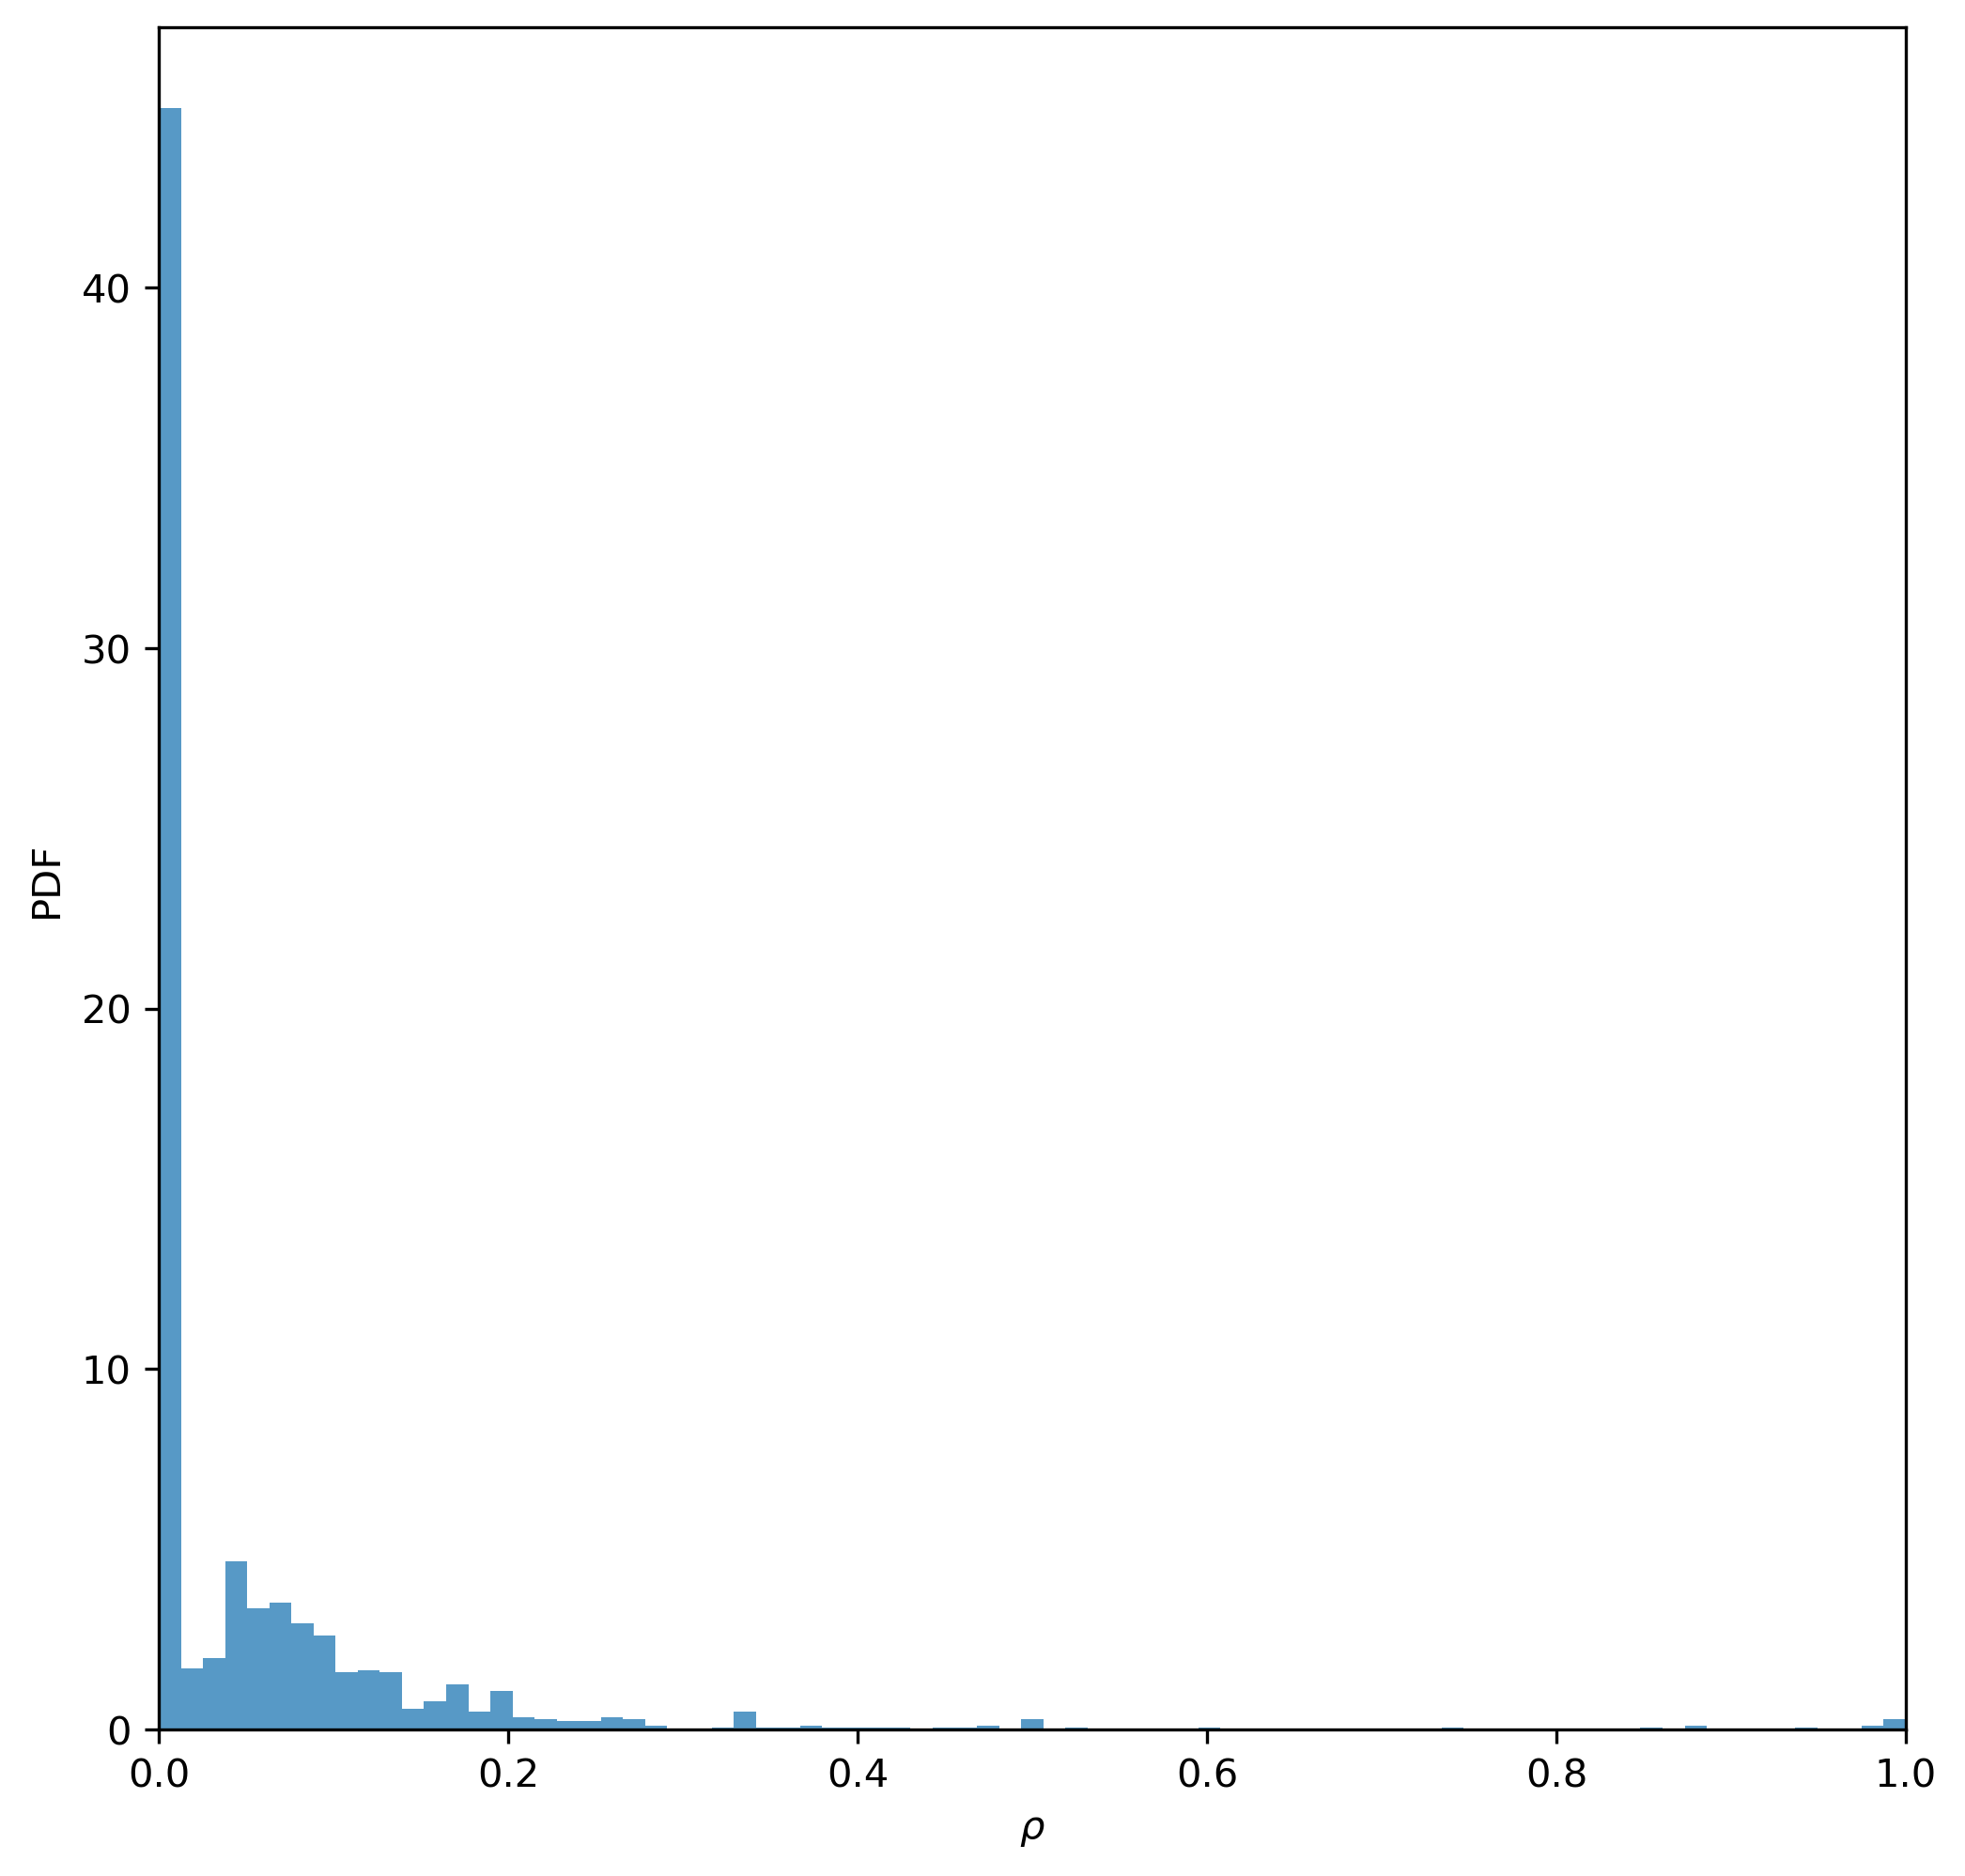

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.1528045068056965


  1%|▋                                                                              | 80/10000 [00:10<20:59,  7.88it/s]


Loops  81
Error margin:  [8.98887748e-06]


8574it [00:05, 1655.66it/s]


AUC:  0.9381721254748423
AUP:  0.8899750884564971
Transductive performance:
AUC:  0.9391738888292107
AUP:  0.8963040981887308


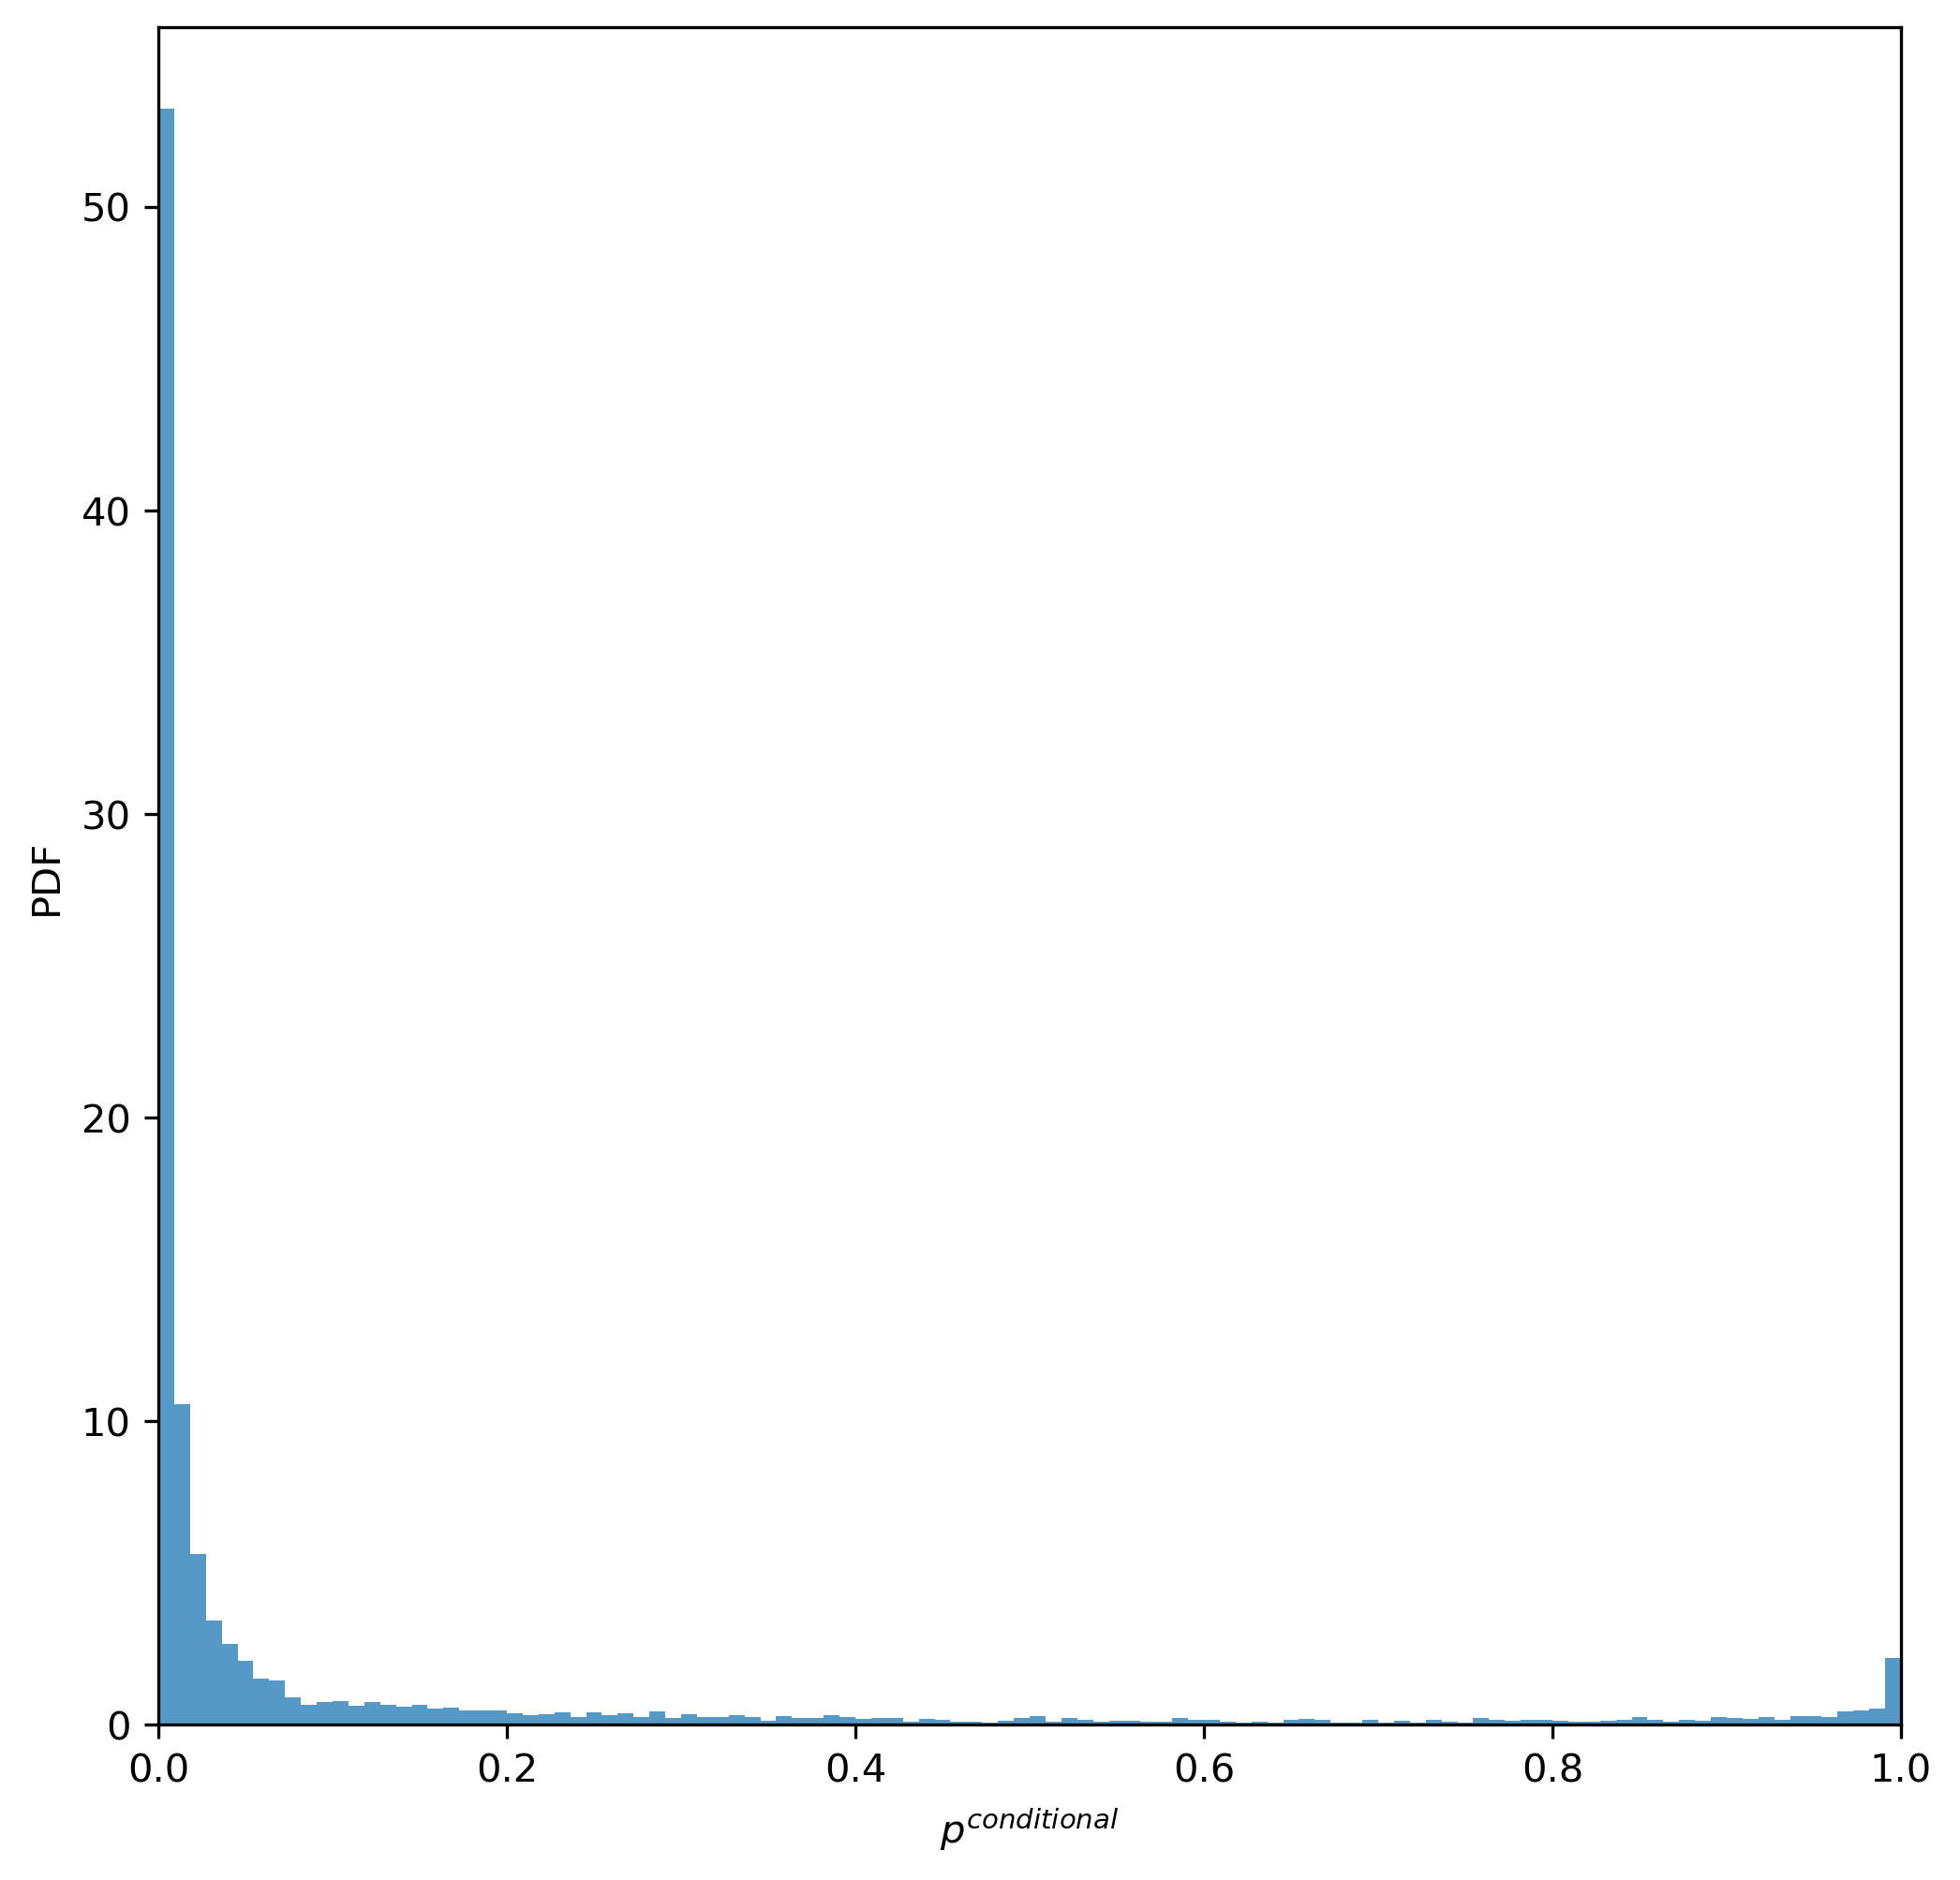

In [59]:
run_configuration_model(network_data_BC)

# Poisson with correlation

100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 6116.01it/s]


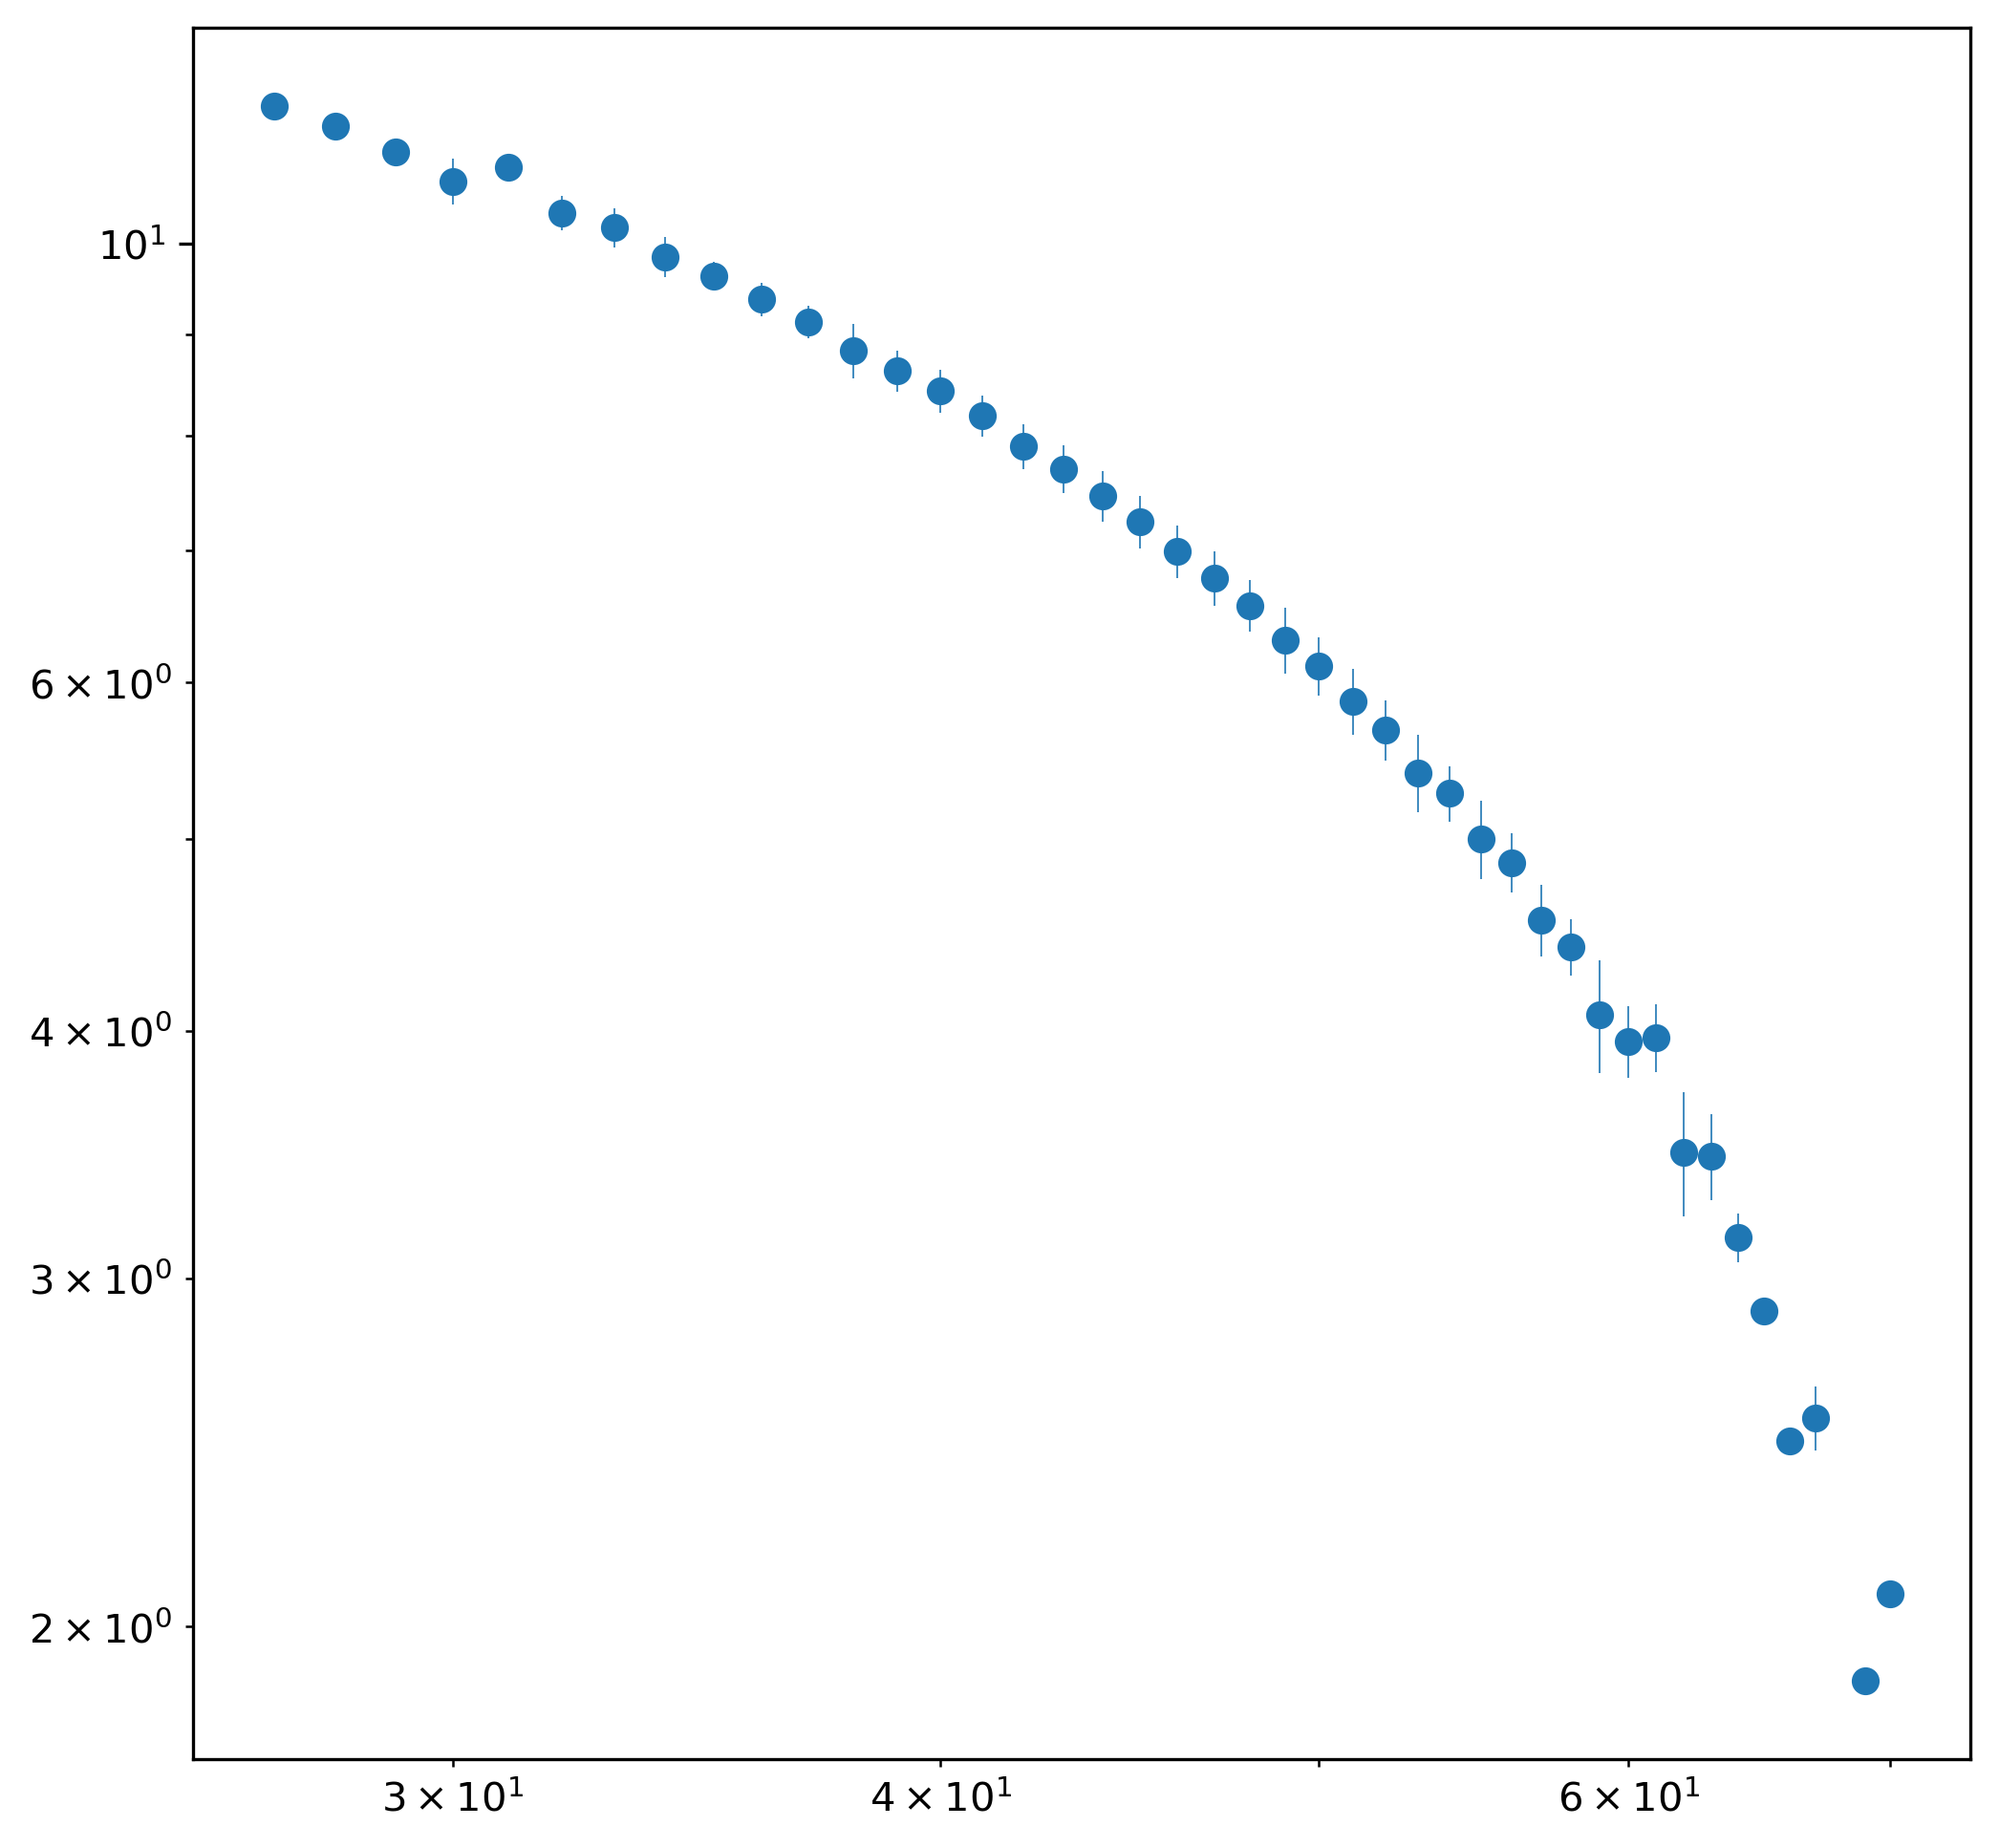

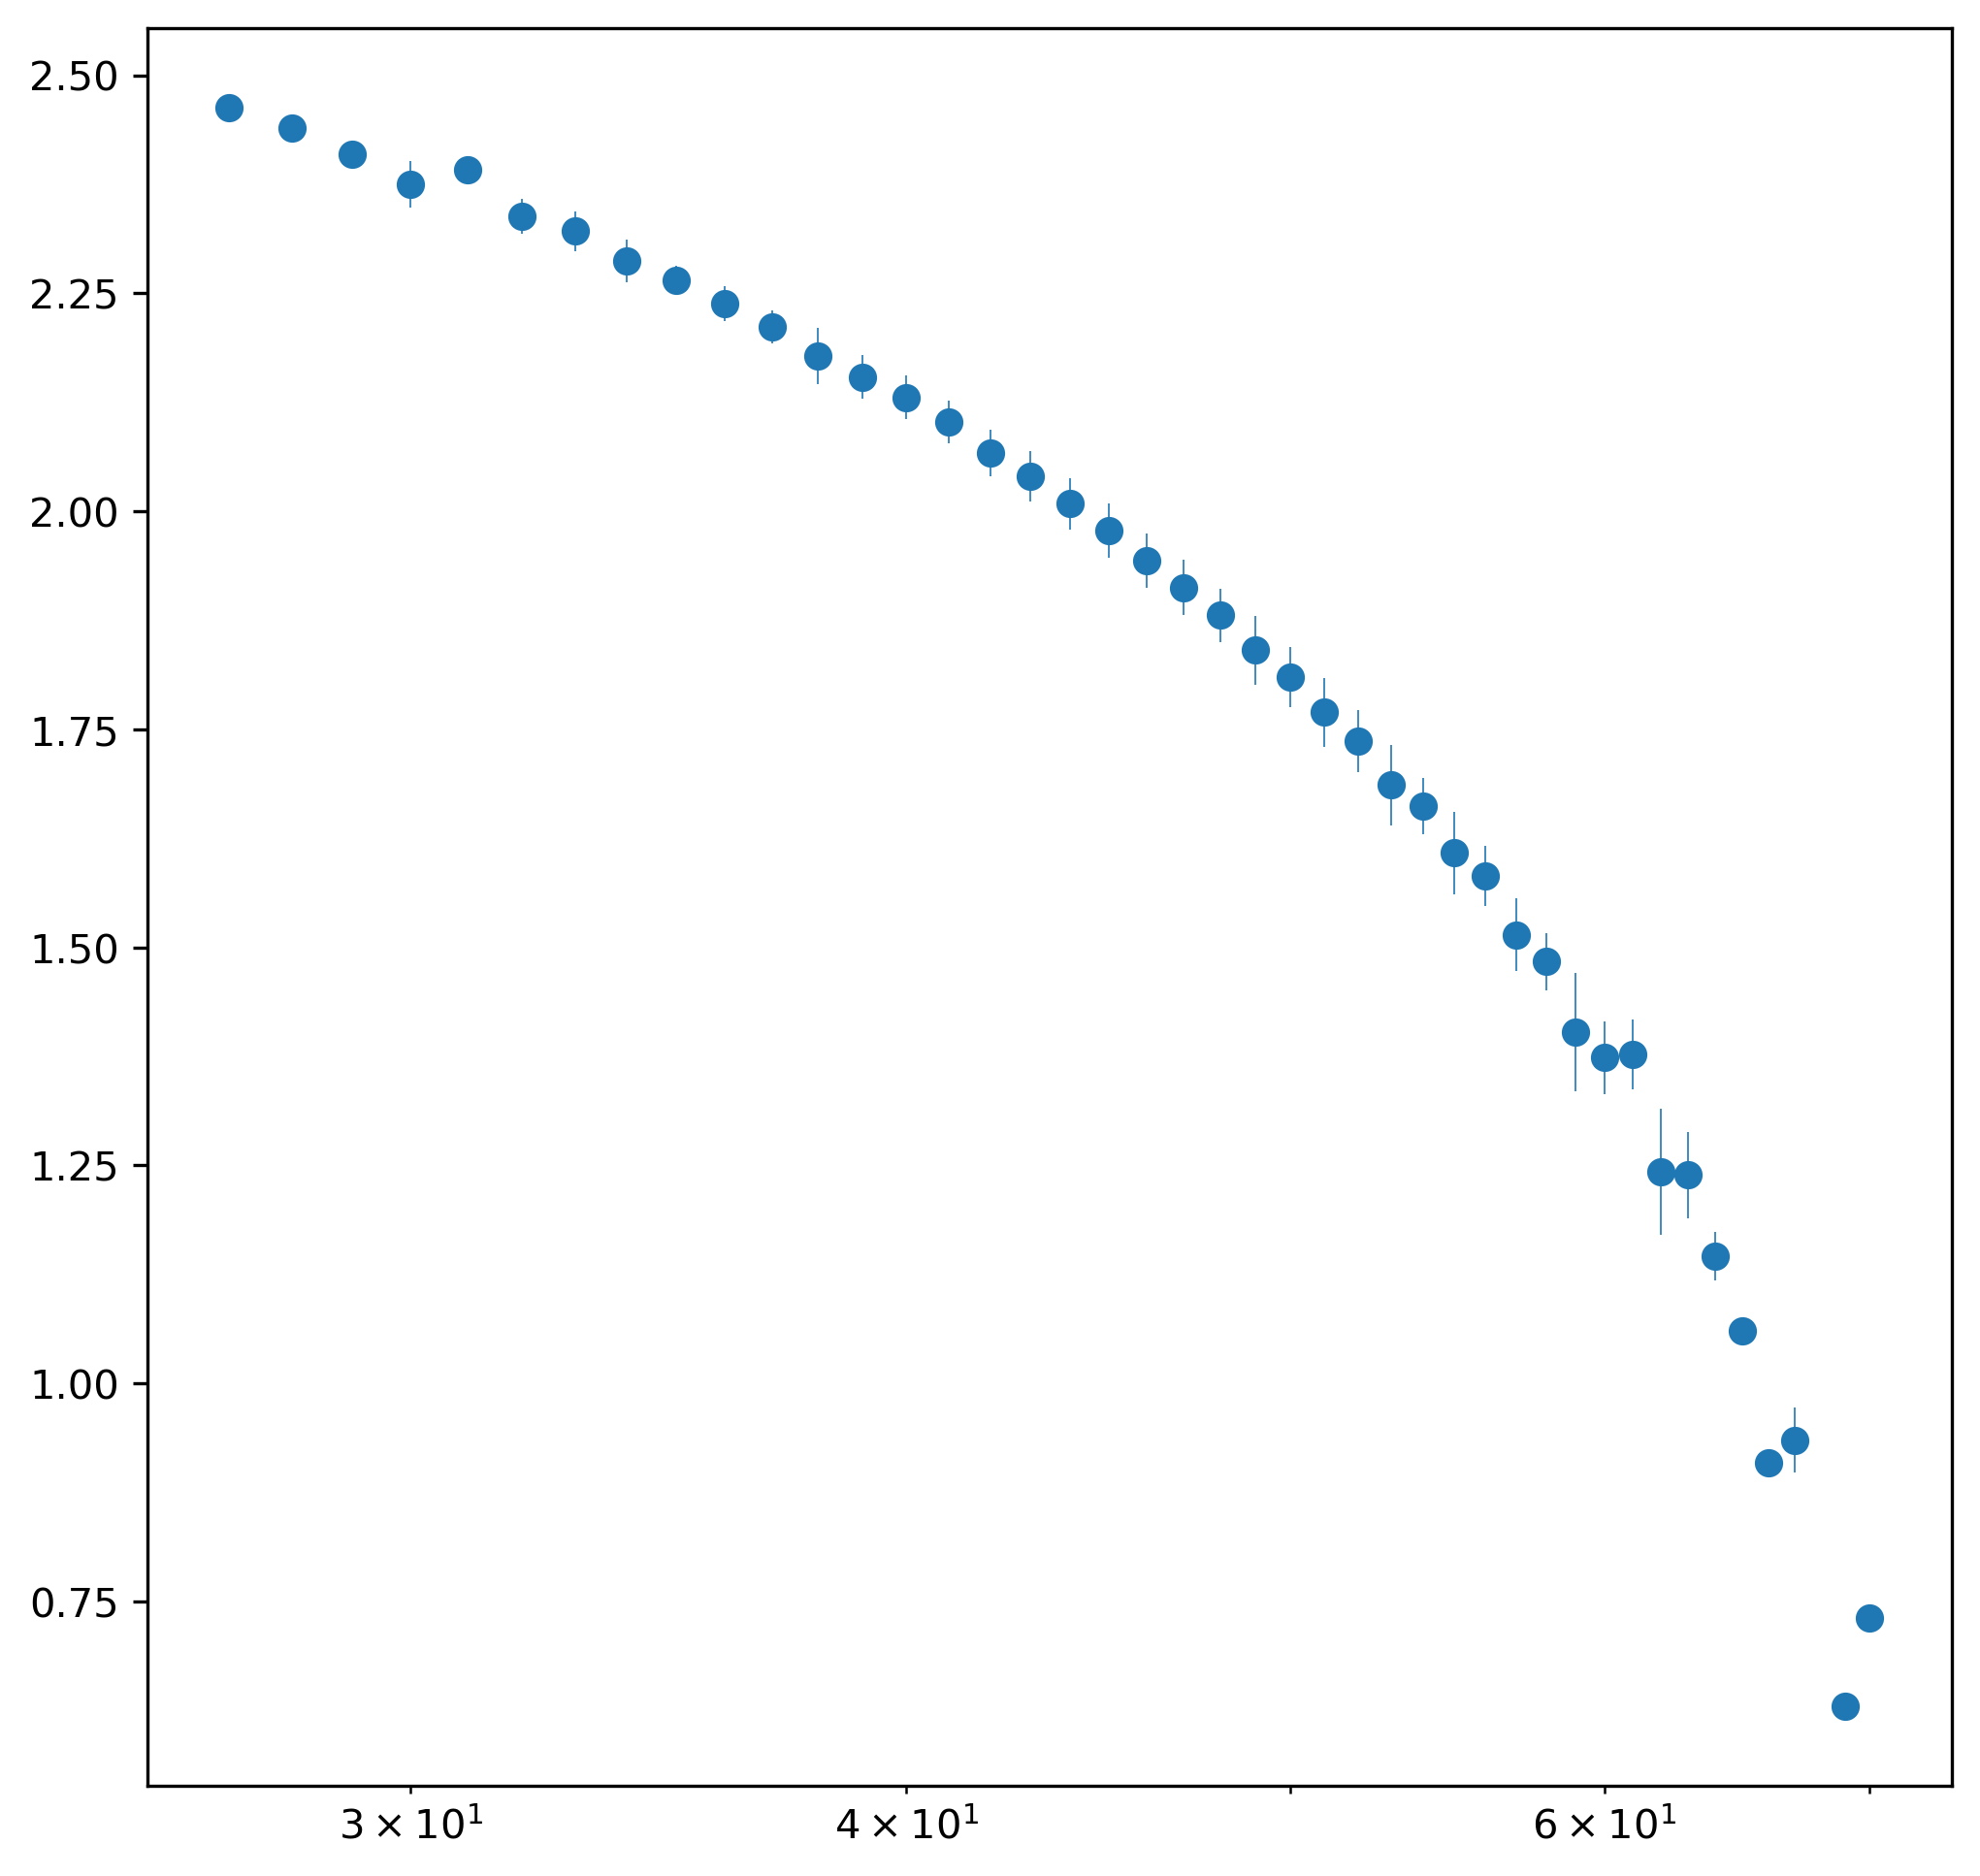

100%|█████████████████████████████████████████████████████████████████████████| 34822/34822 [00:00<00:00, 36977.38it/s]


Threshold:  5.550417075369605


In [60]:
network_data_BC_P, node_degree_list = sampling_with_corrP(kvec, anti_corr, mean_log_Kd, std_log_Kd, kd_list, p_bind = THR, iterl=iterl)

100%|█████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:02<00:00, 556.68it/s]


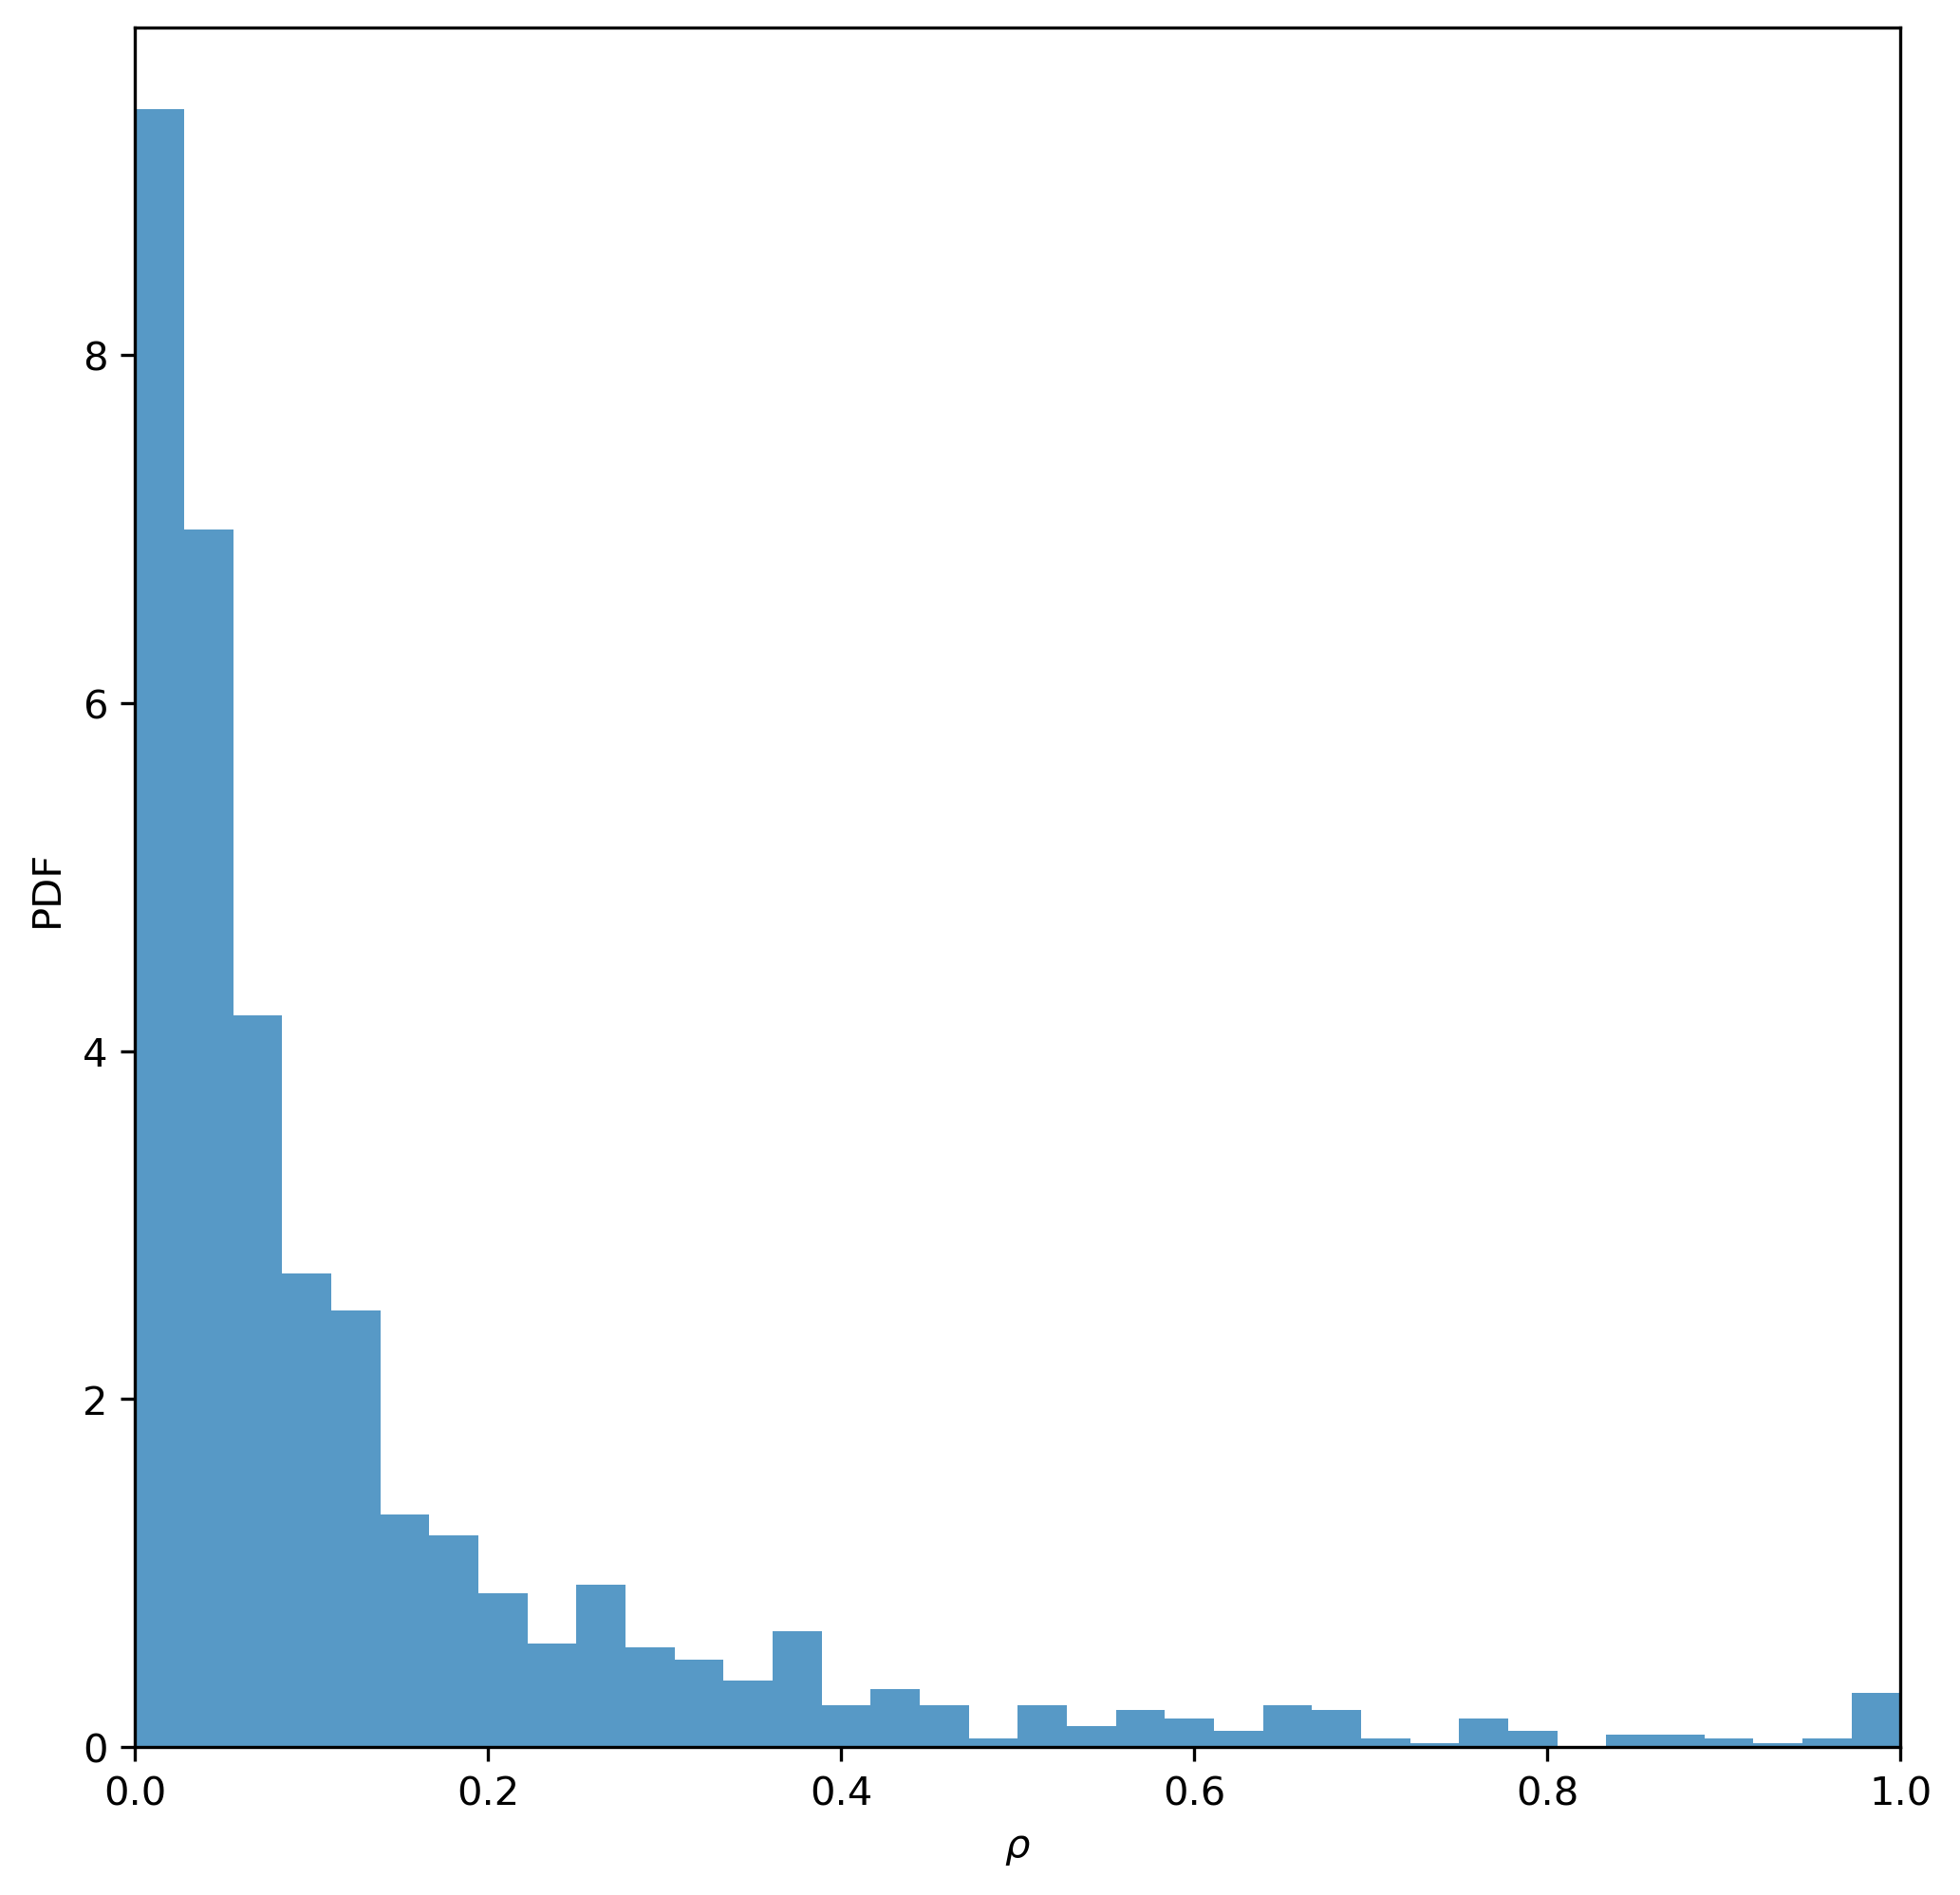

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15223134799839183


  3%|██▏                                                                           | 274/10000 [00:36<21:21,  7.59it/s]


Loops  275
Error margin:  [9.90909017e-06]


10447it [00:04, 2561.80it/s]


AUC:  0.9165962591089112
AUP:  0.8654000793399002
Transductive performance:
AUC:  0.9165962591089112
AUP:  0.8654000793399002


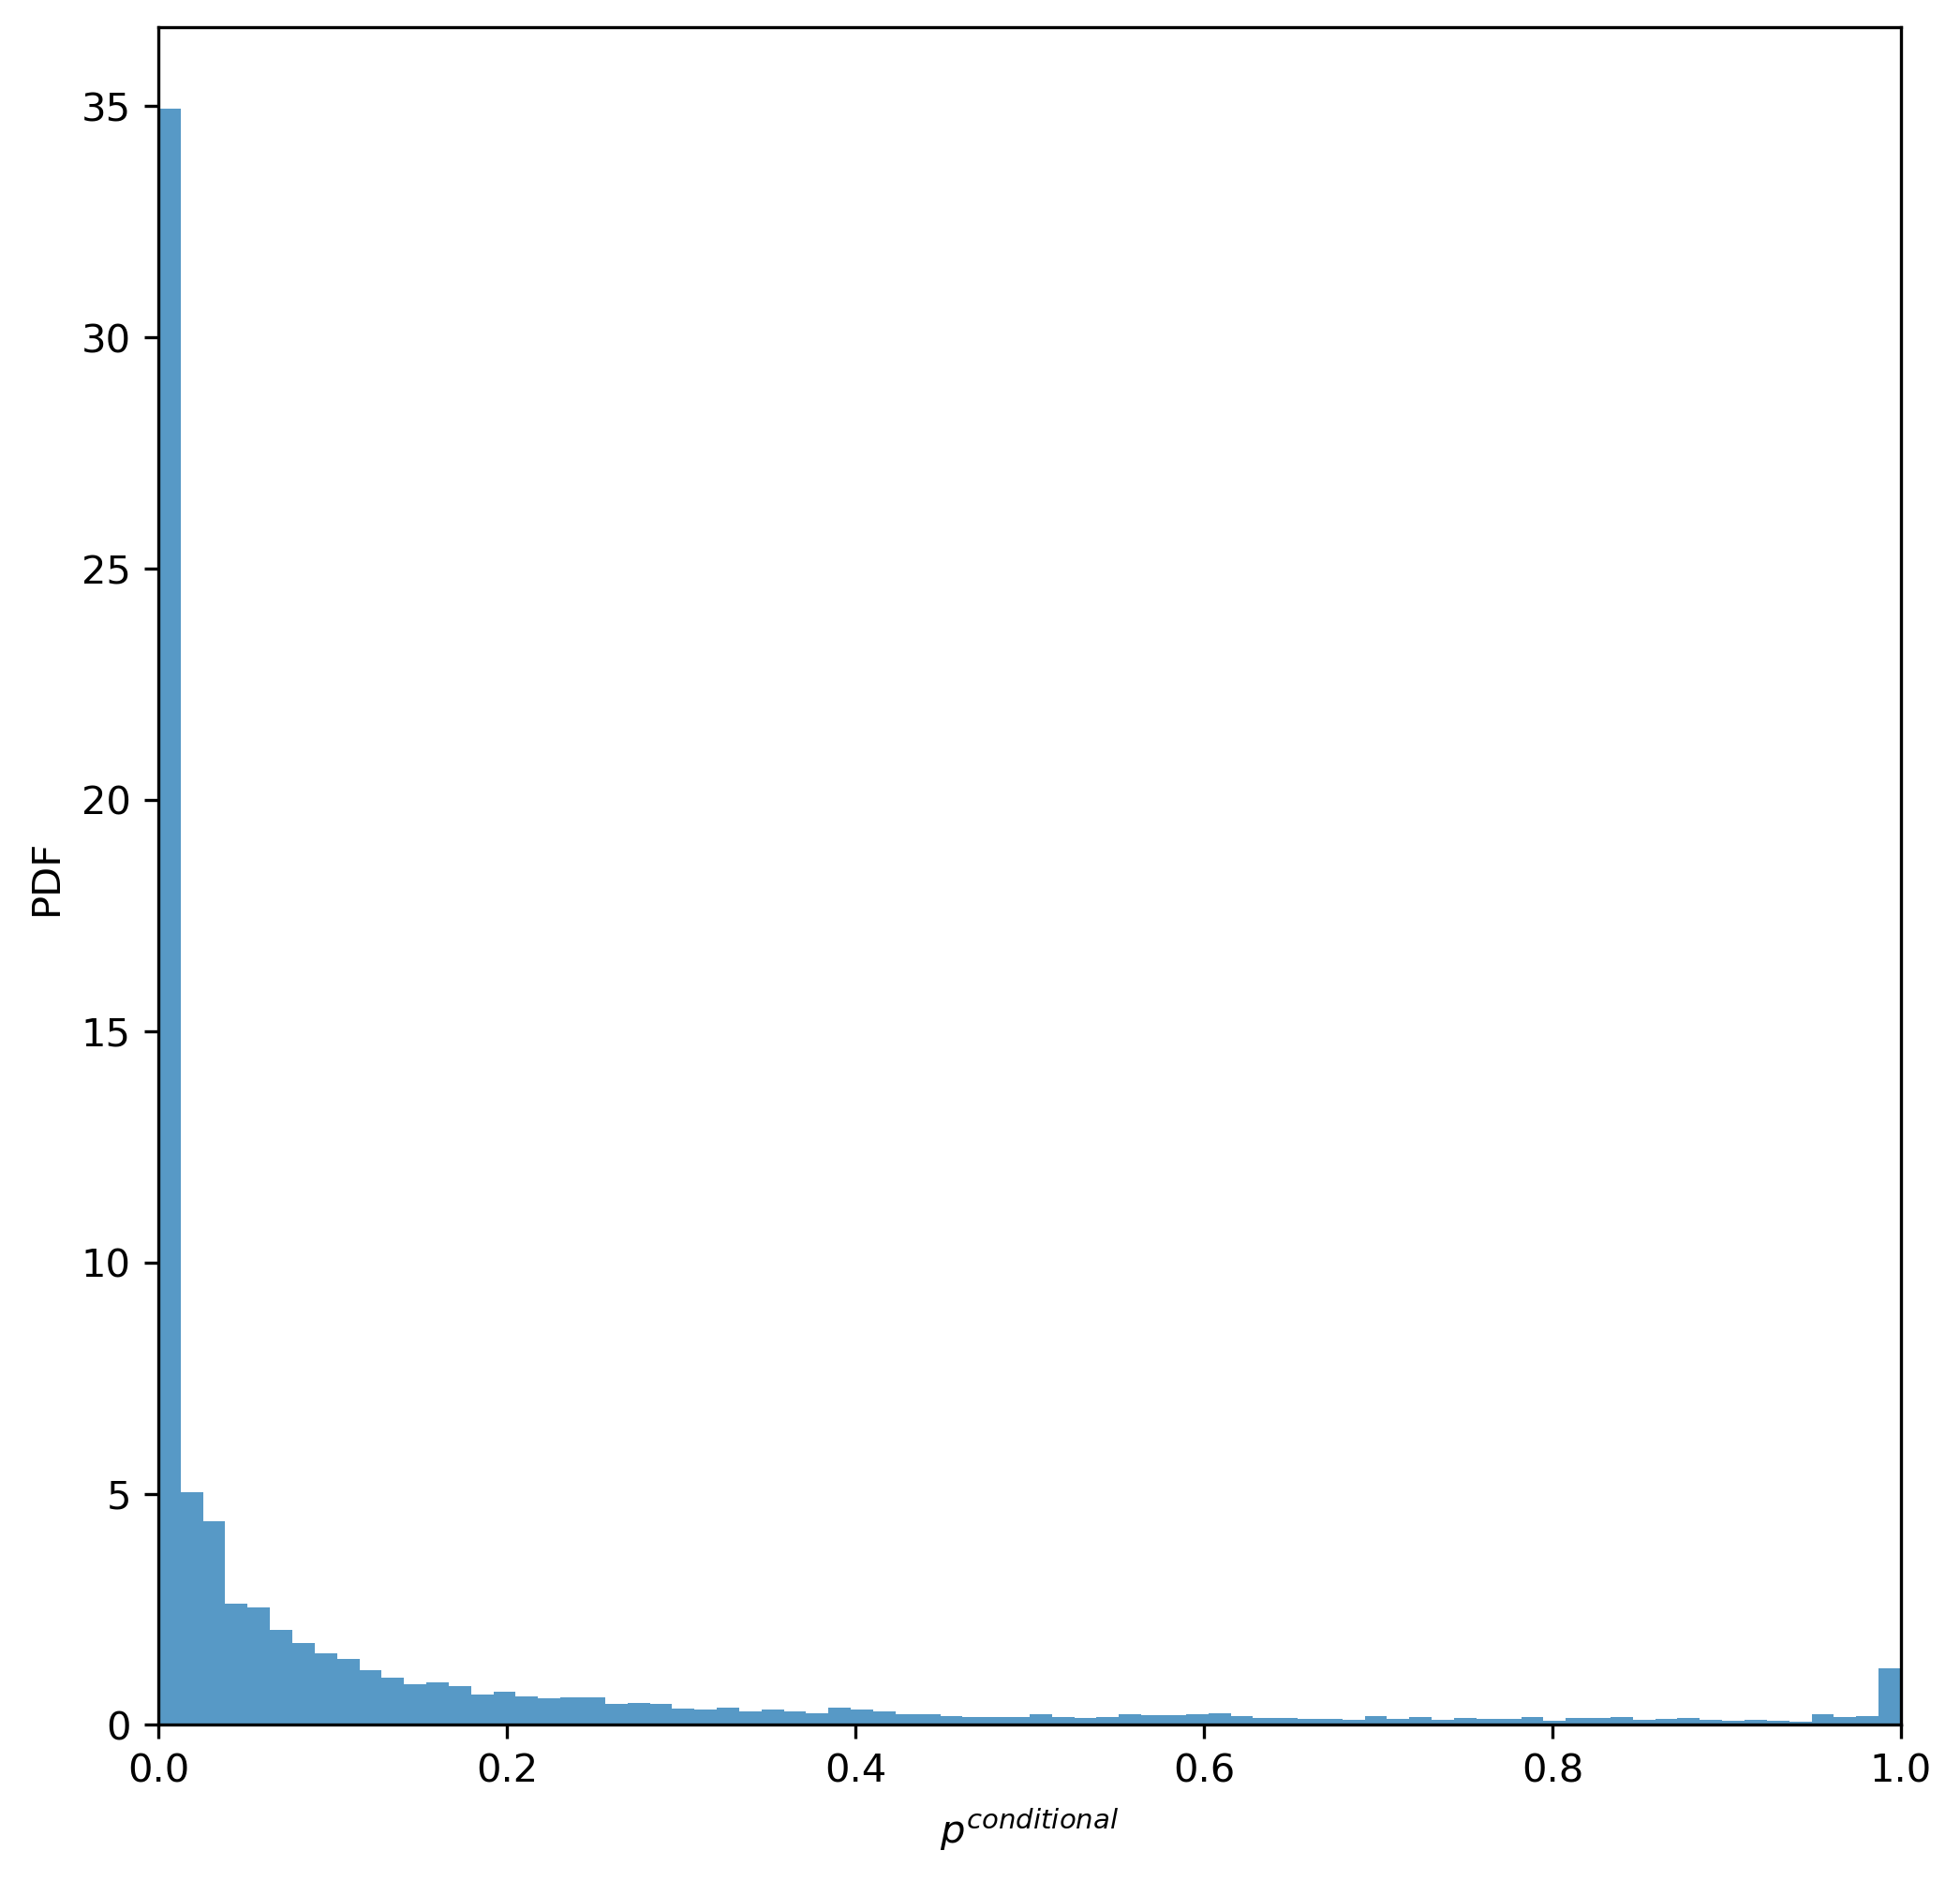

In [61]:
run_configuration_model(network_data_BC_P, loops=10000)

# Power-law without correlation

100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 1902.44it/s]


Correlation between k and <Kd> at edge level:  SpearmanrResult(correlation=-0.11192805550726238, pvalue=0.1641911758820047)


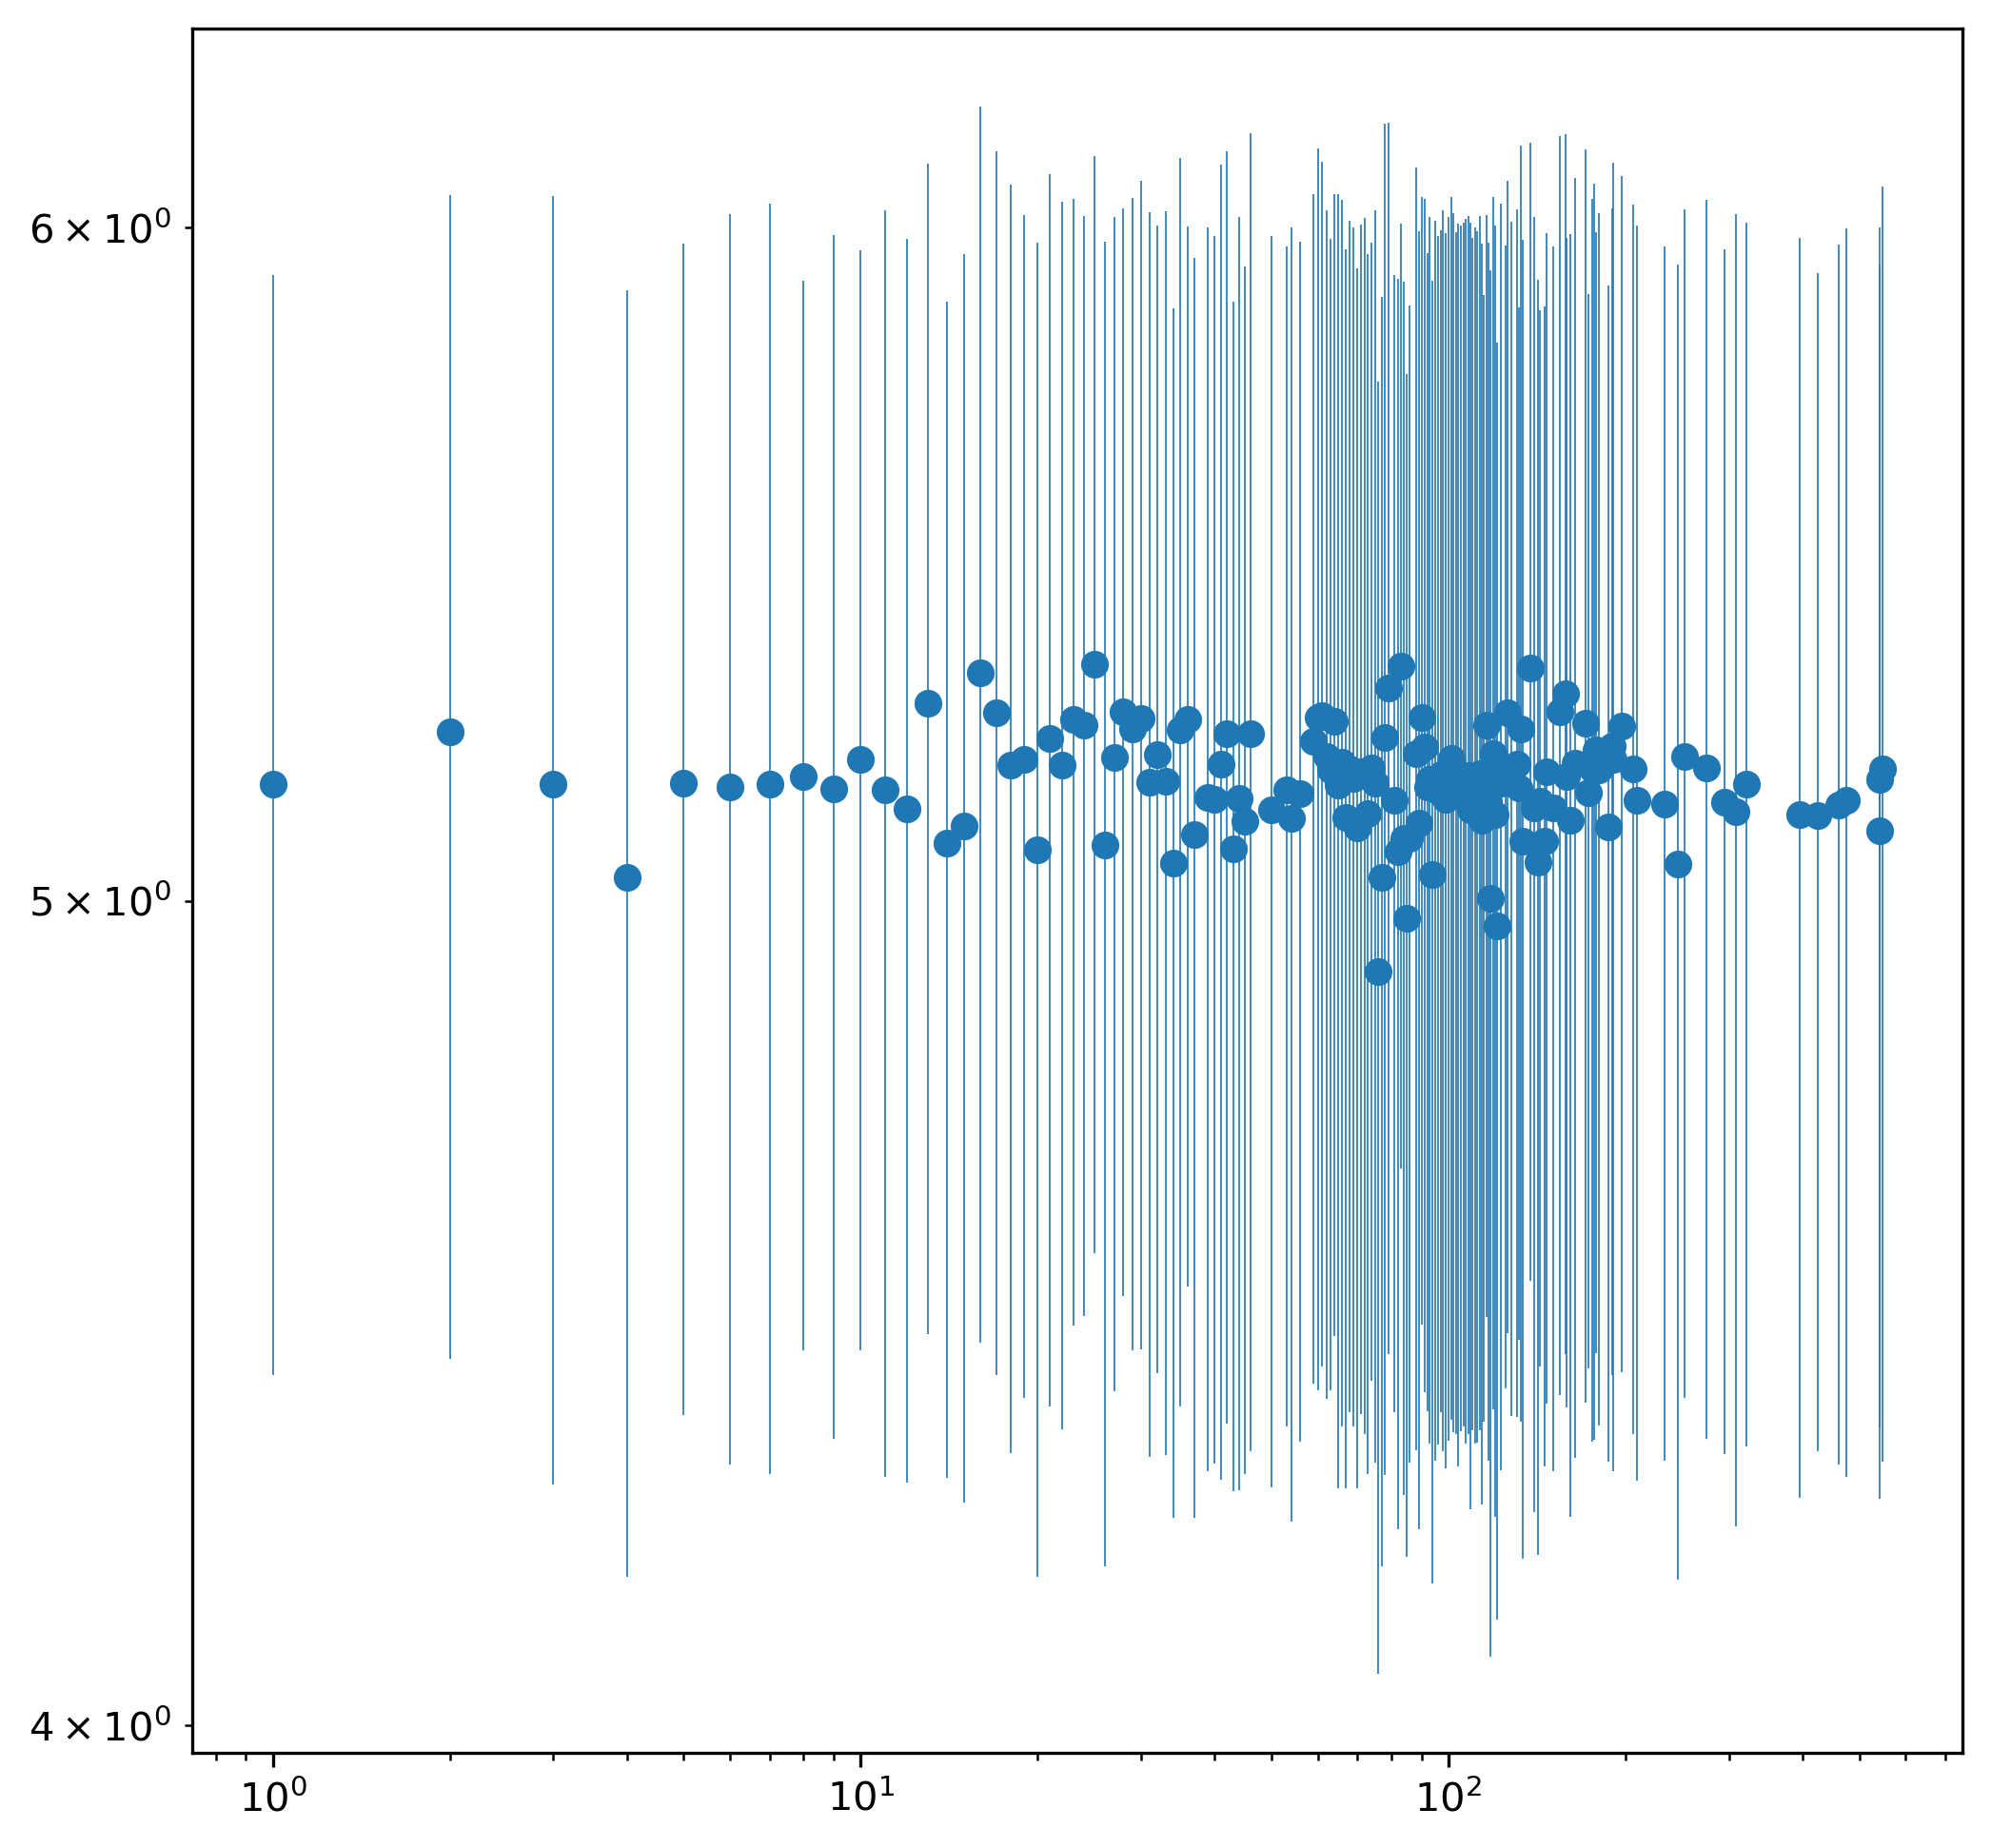

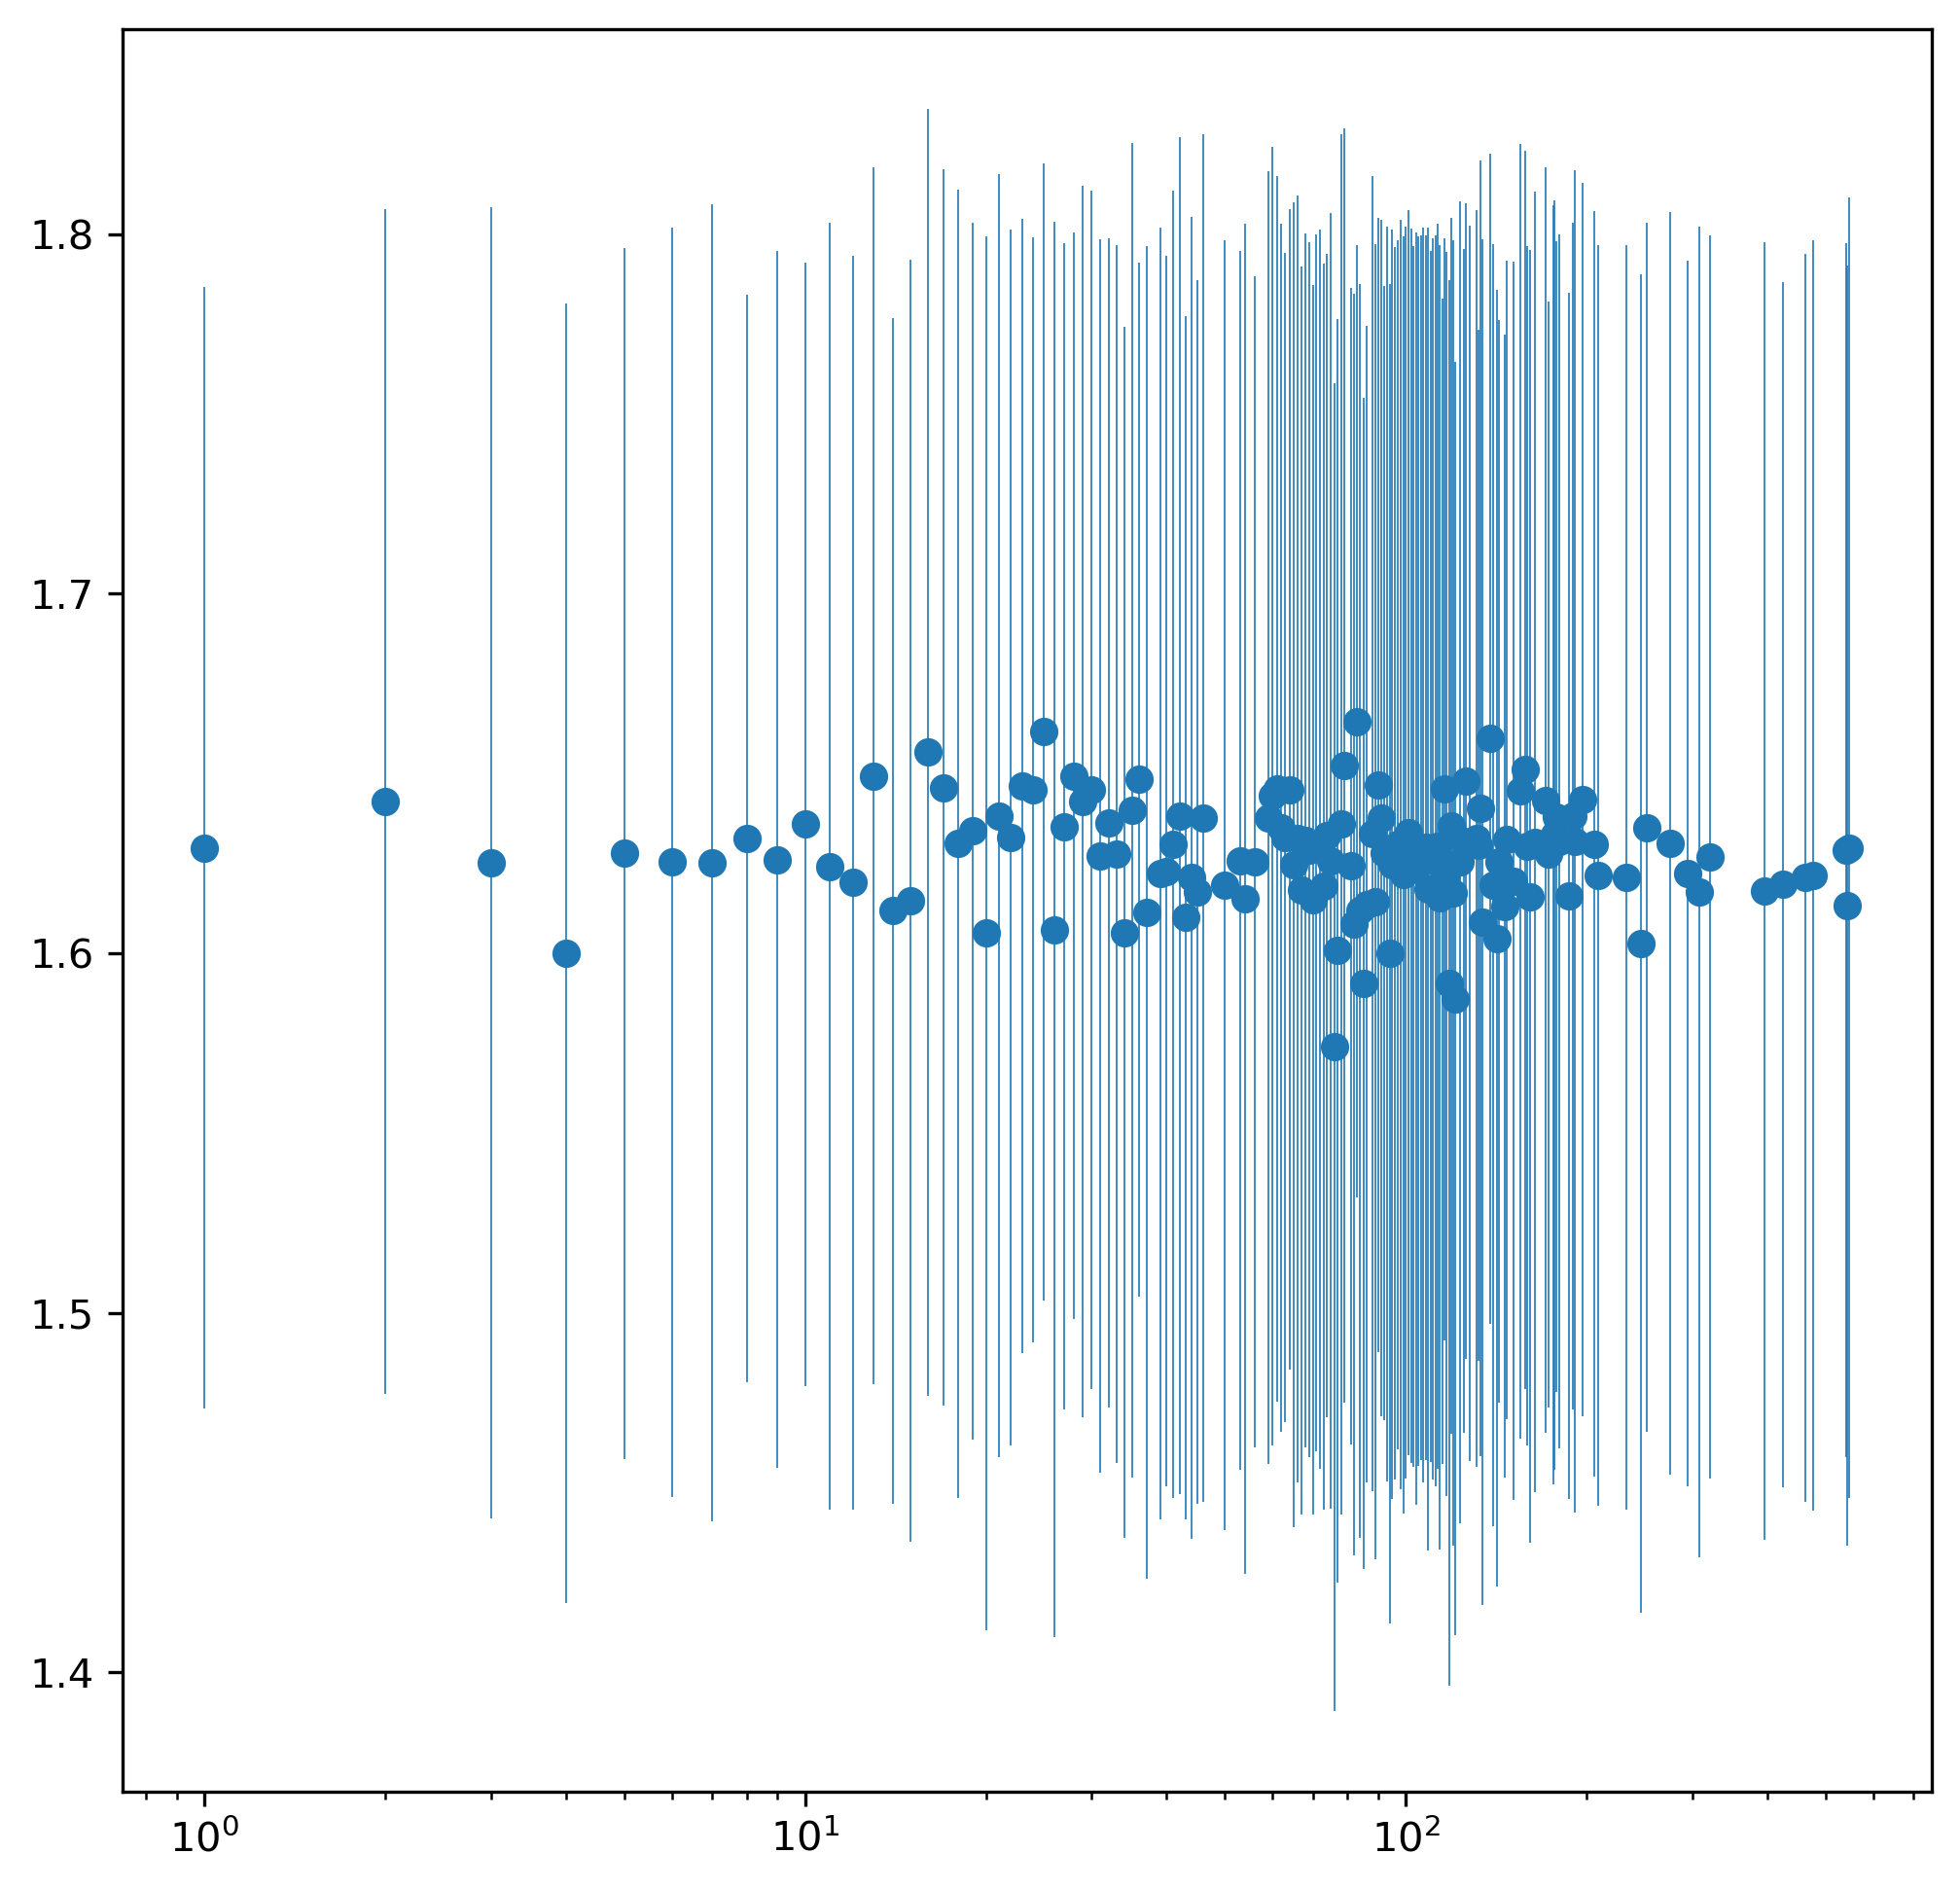

100%|█████████████████████████████████████████████████████████████████████████████| 1383/1383 [00:03<00:00, 397.76it/s]


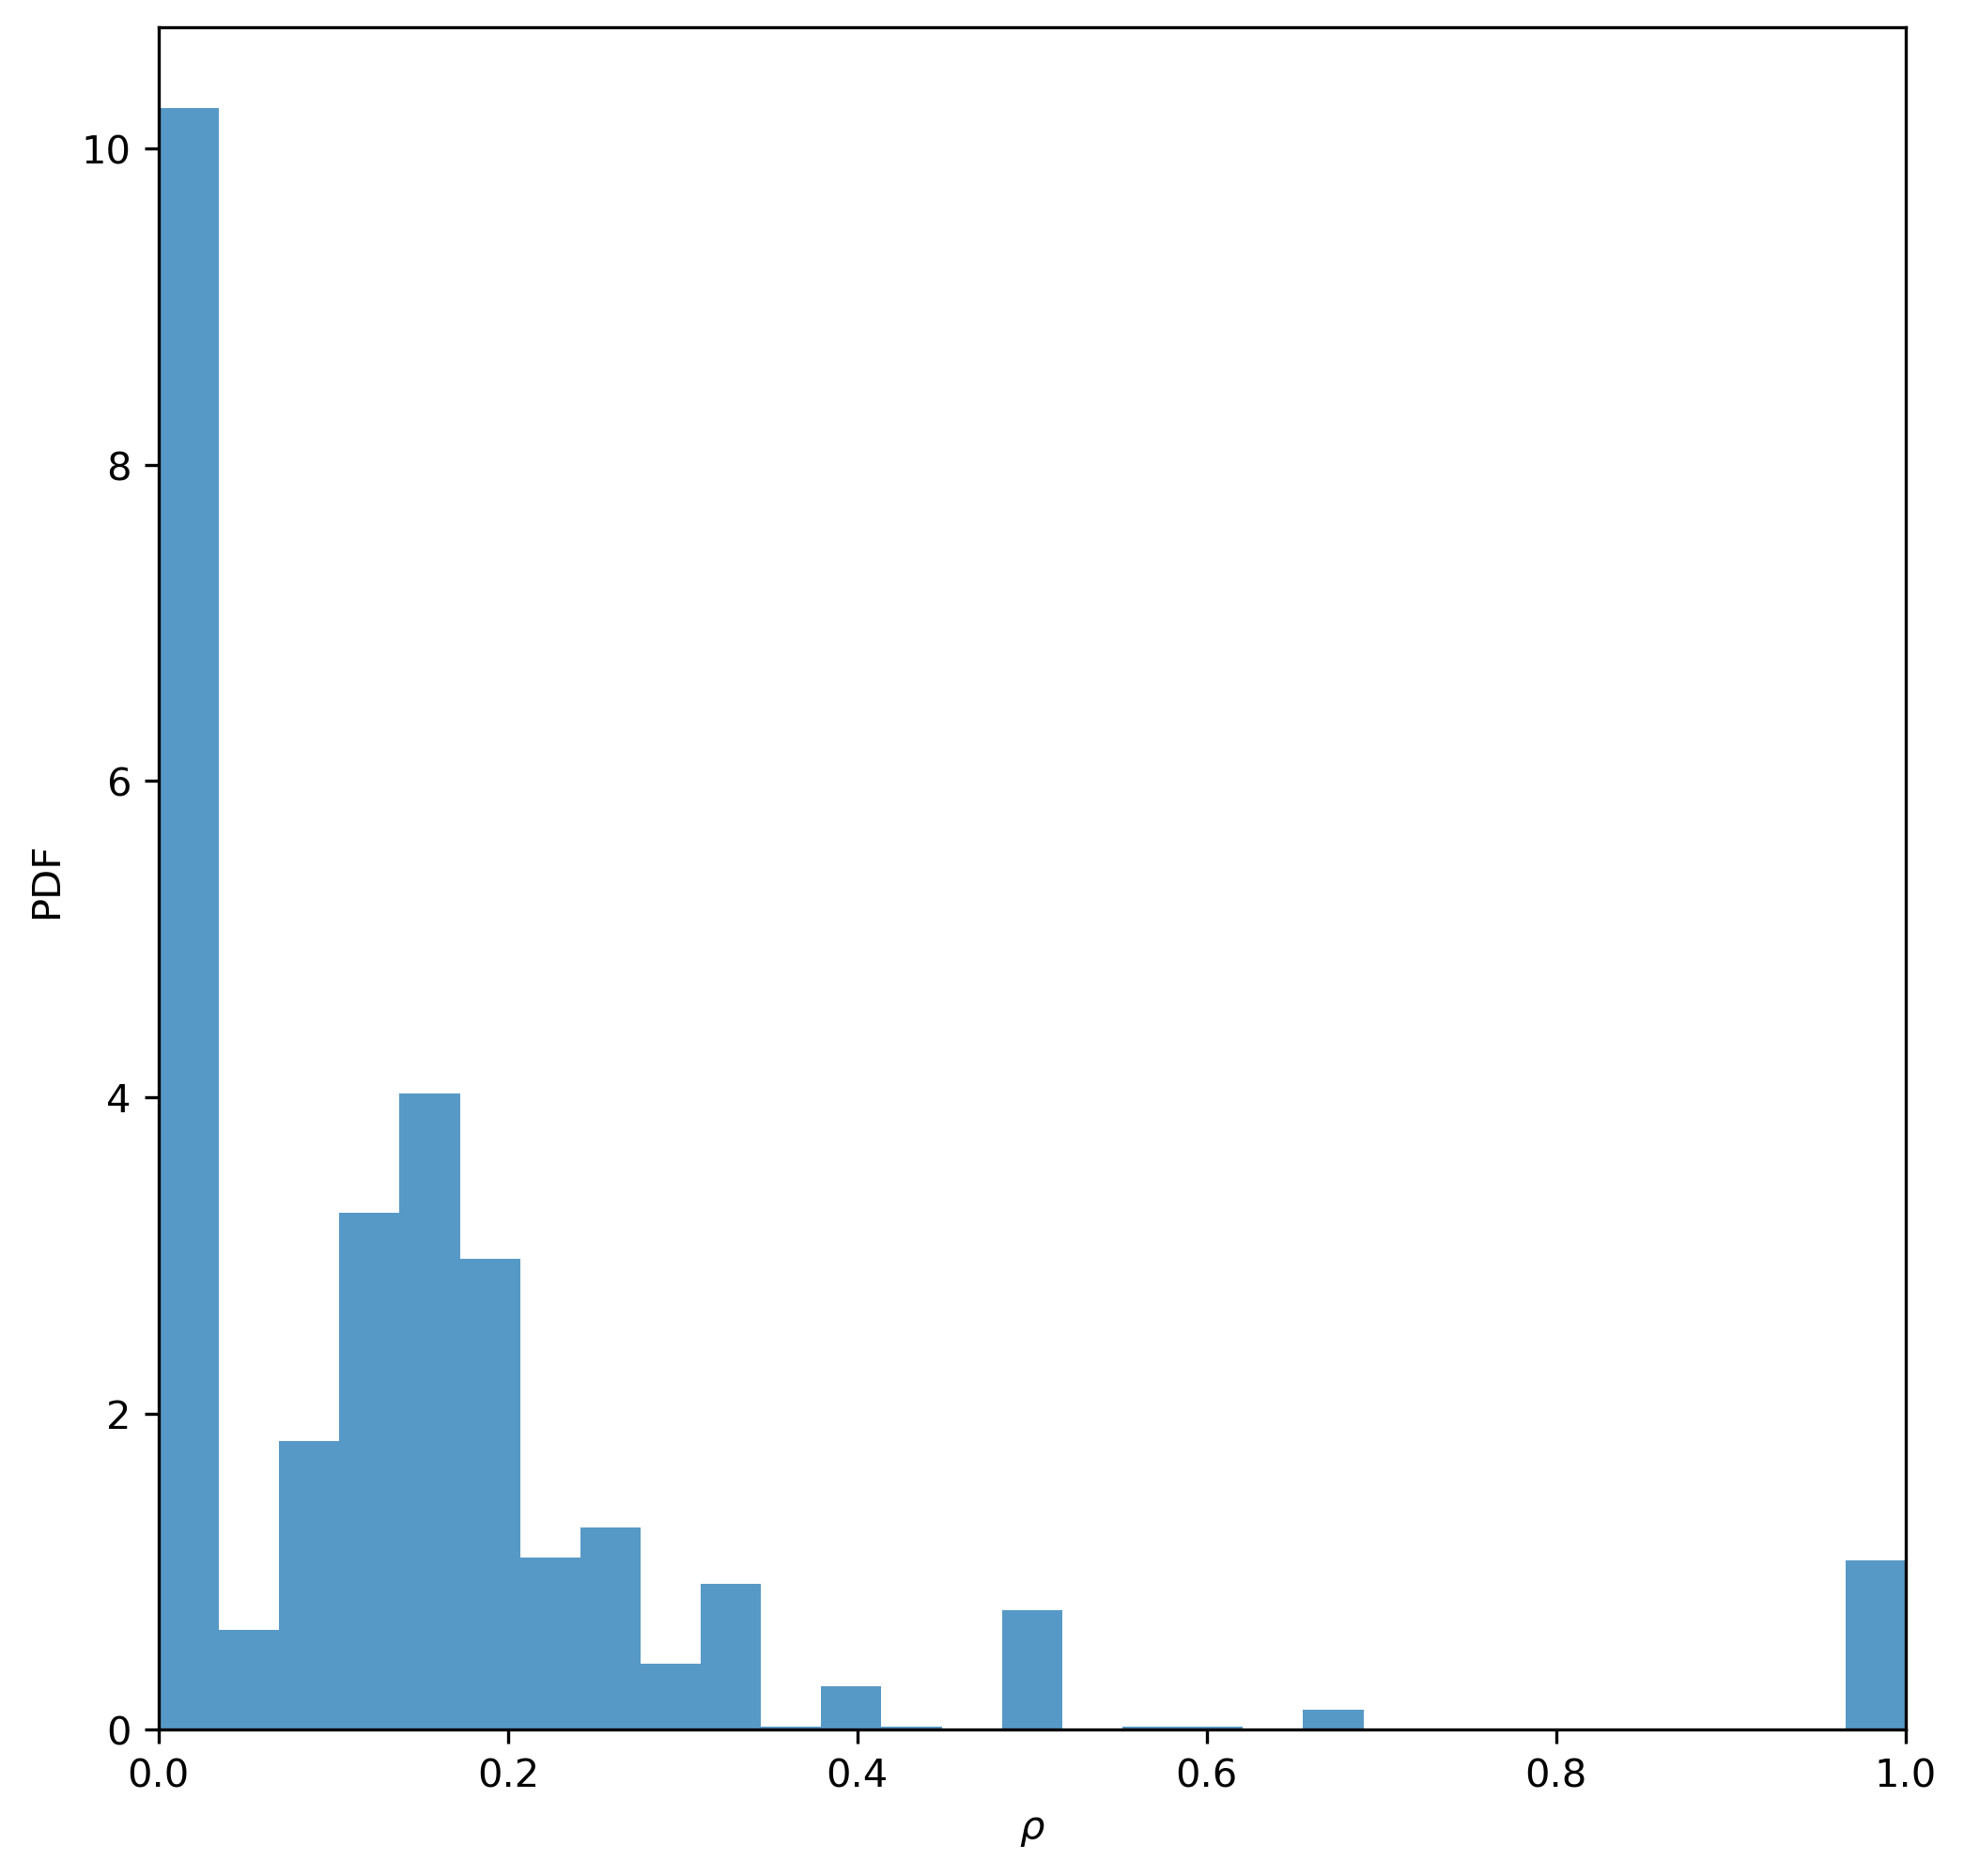

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.1528045068056965


  1%|▋                                                                              | 85/10000 [00:11<22:56,  7.20it/s]


Loops  86
Error margin:  [9.64701575e-06]


8574it [00:04, 1964.57it/s]


AUC:  0.49594816341101916
AUP:  0.1510175830174123
Transductive performance:
AUC:  0.49594748118774246
AUP:  0.15173636395733398


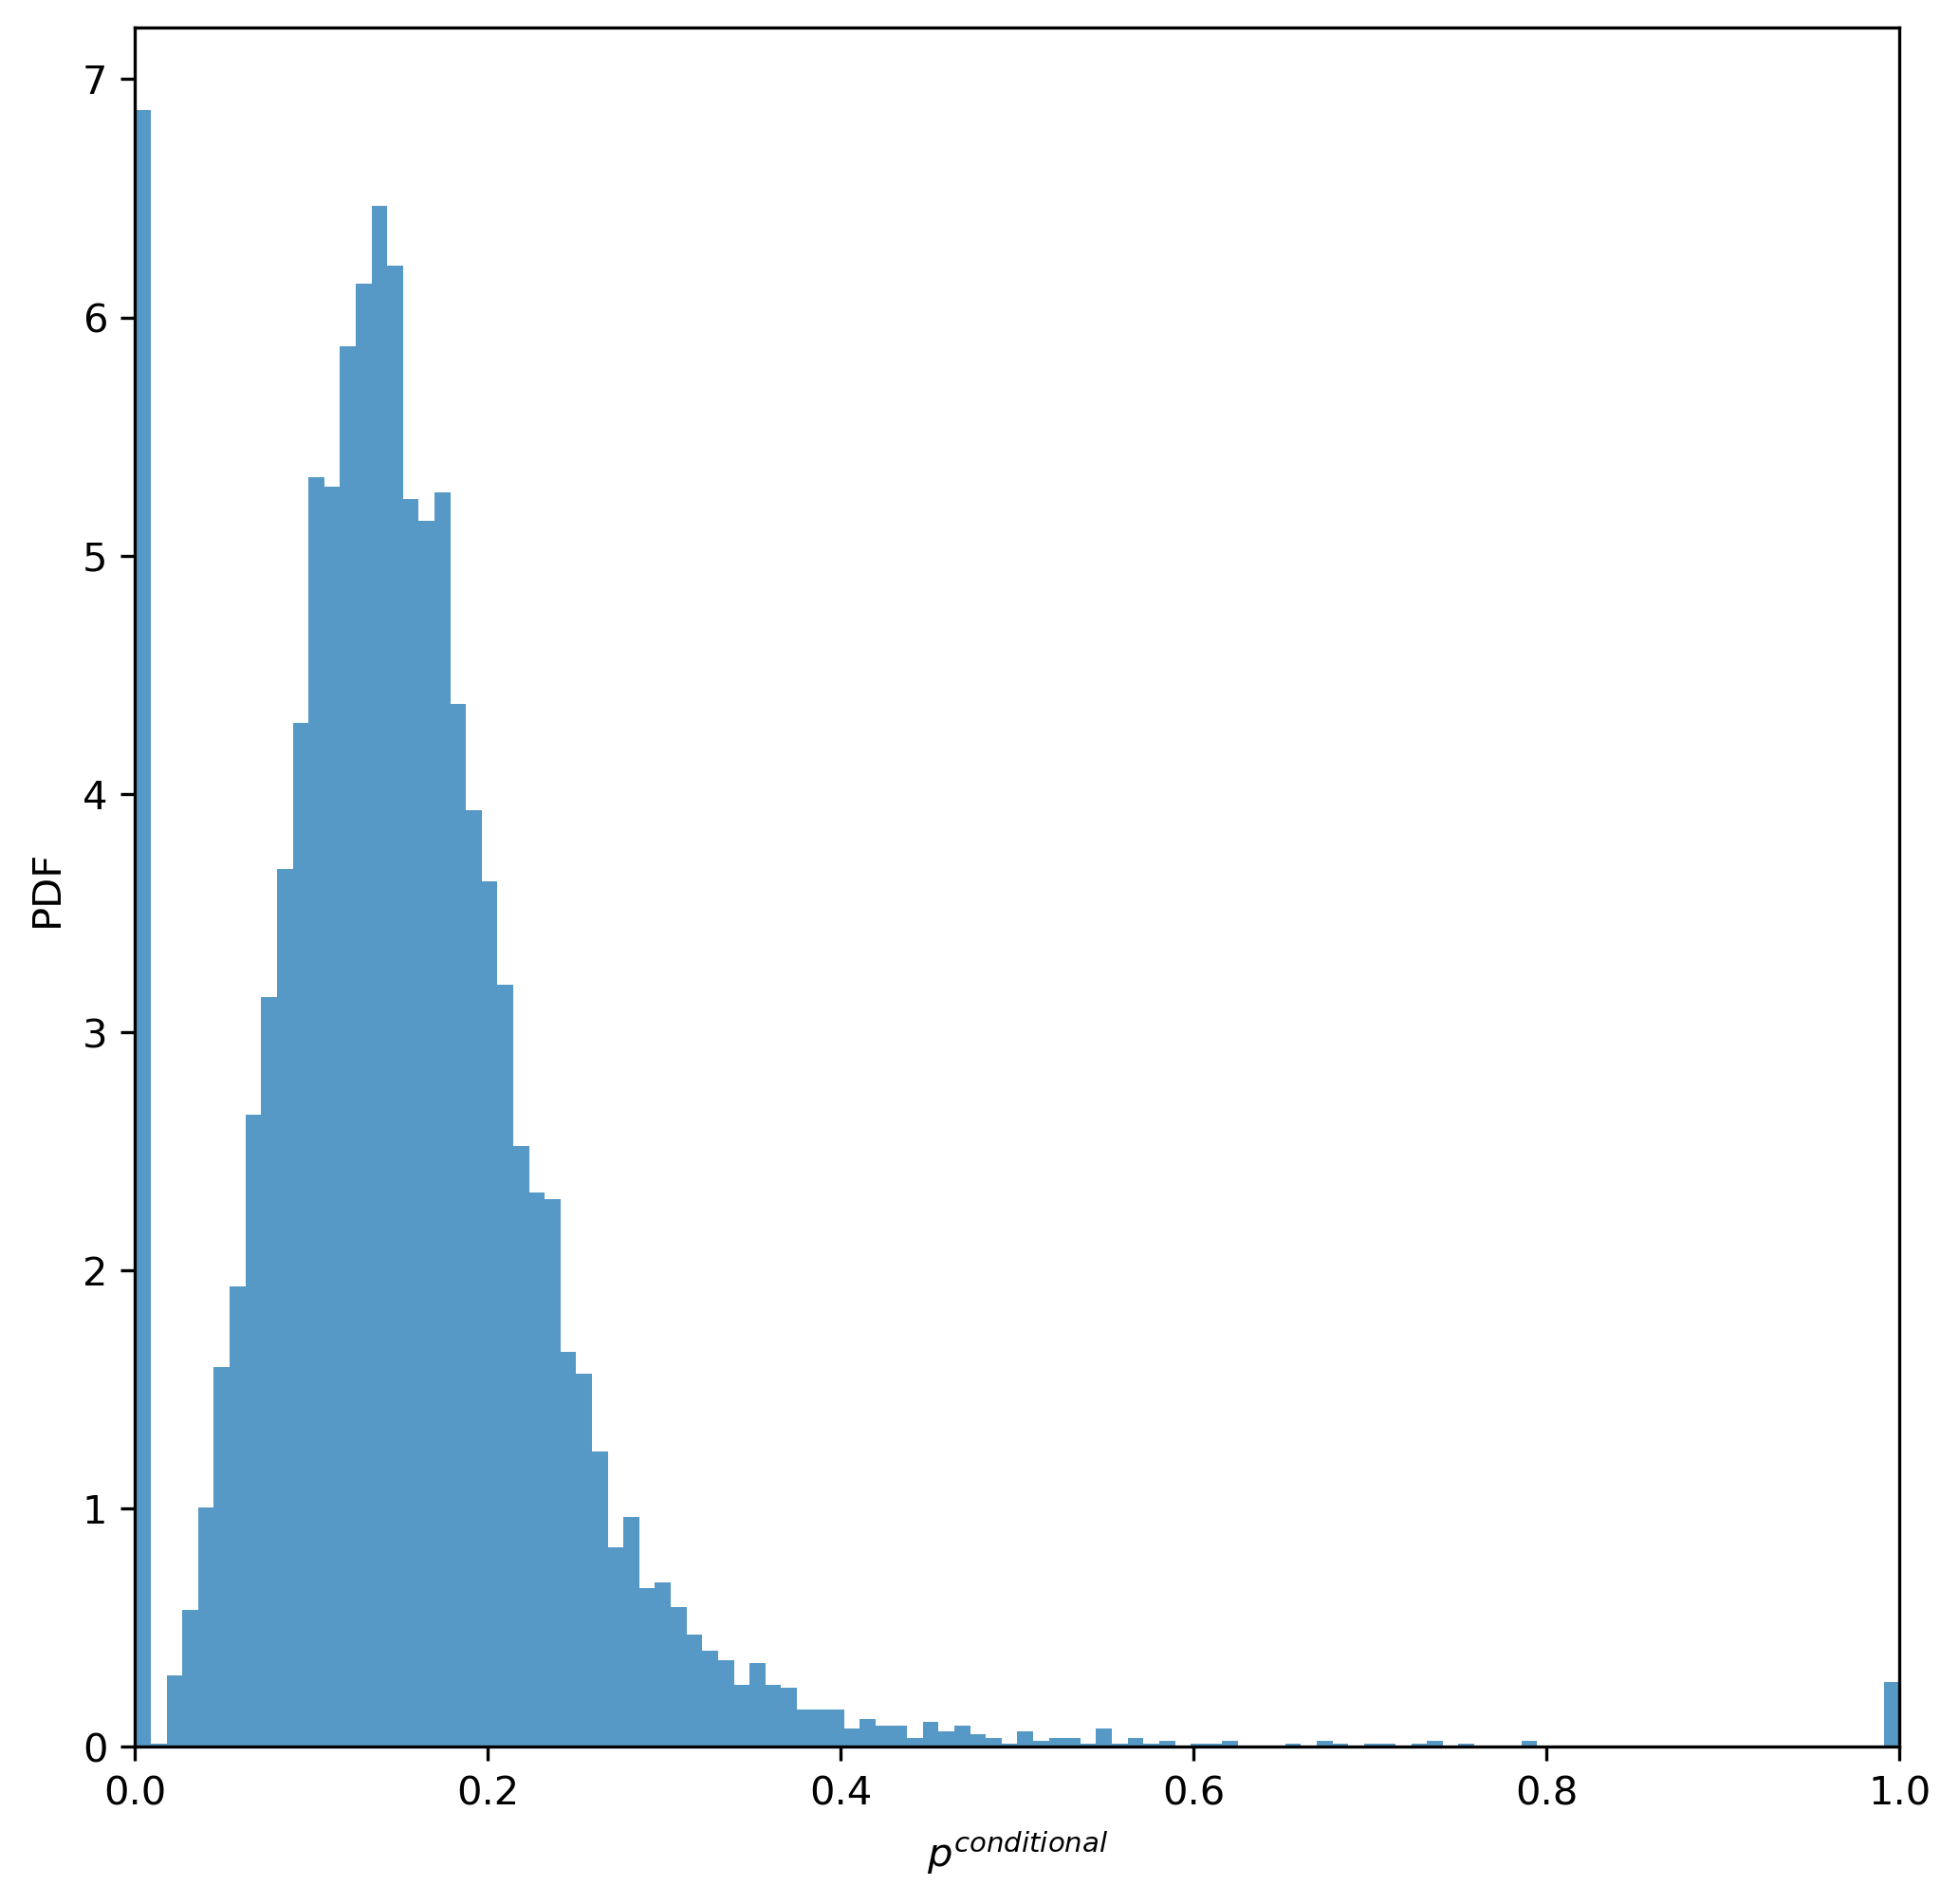

In [62]:
network_data_shuffled = remove_correlation_run_configuration_model(network_data_BC, precision=10**(-5), loops=10000)

# Poisson without Correlation

100%|█████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 728.82it/s]


Correlation between k and <Kd> at edge level:  SpearmanrResult(correlation=-0.014950166112956811, pvalue=0.9241947097001557)


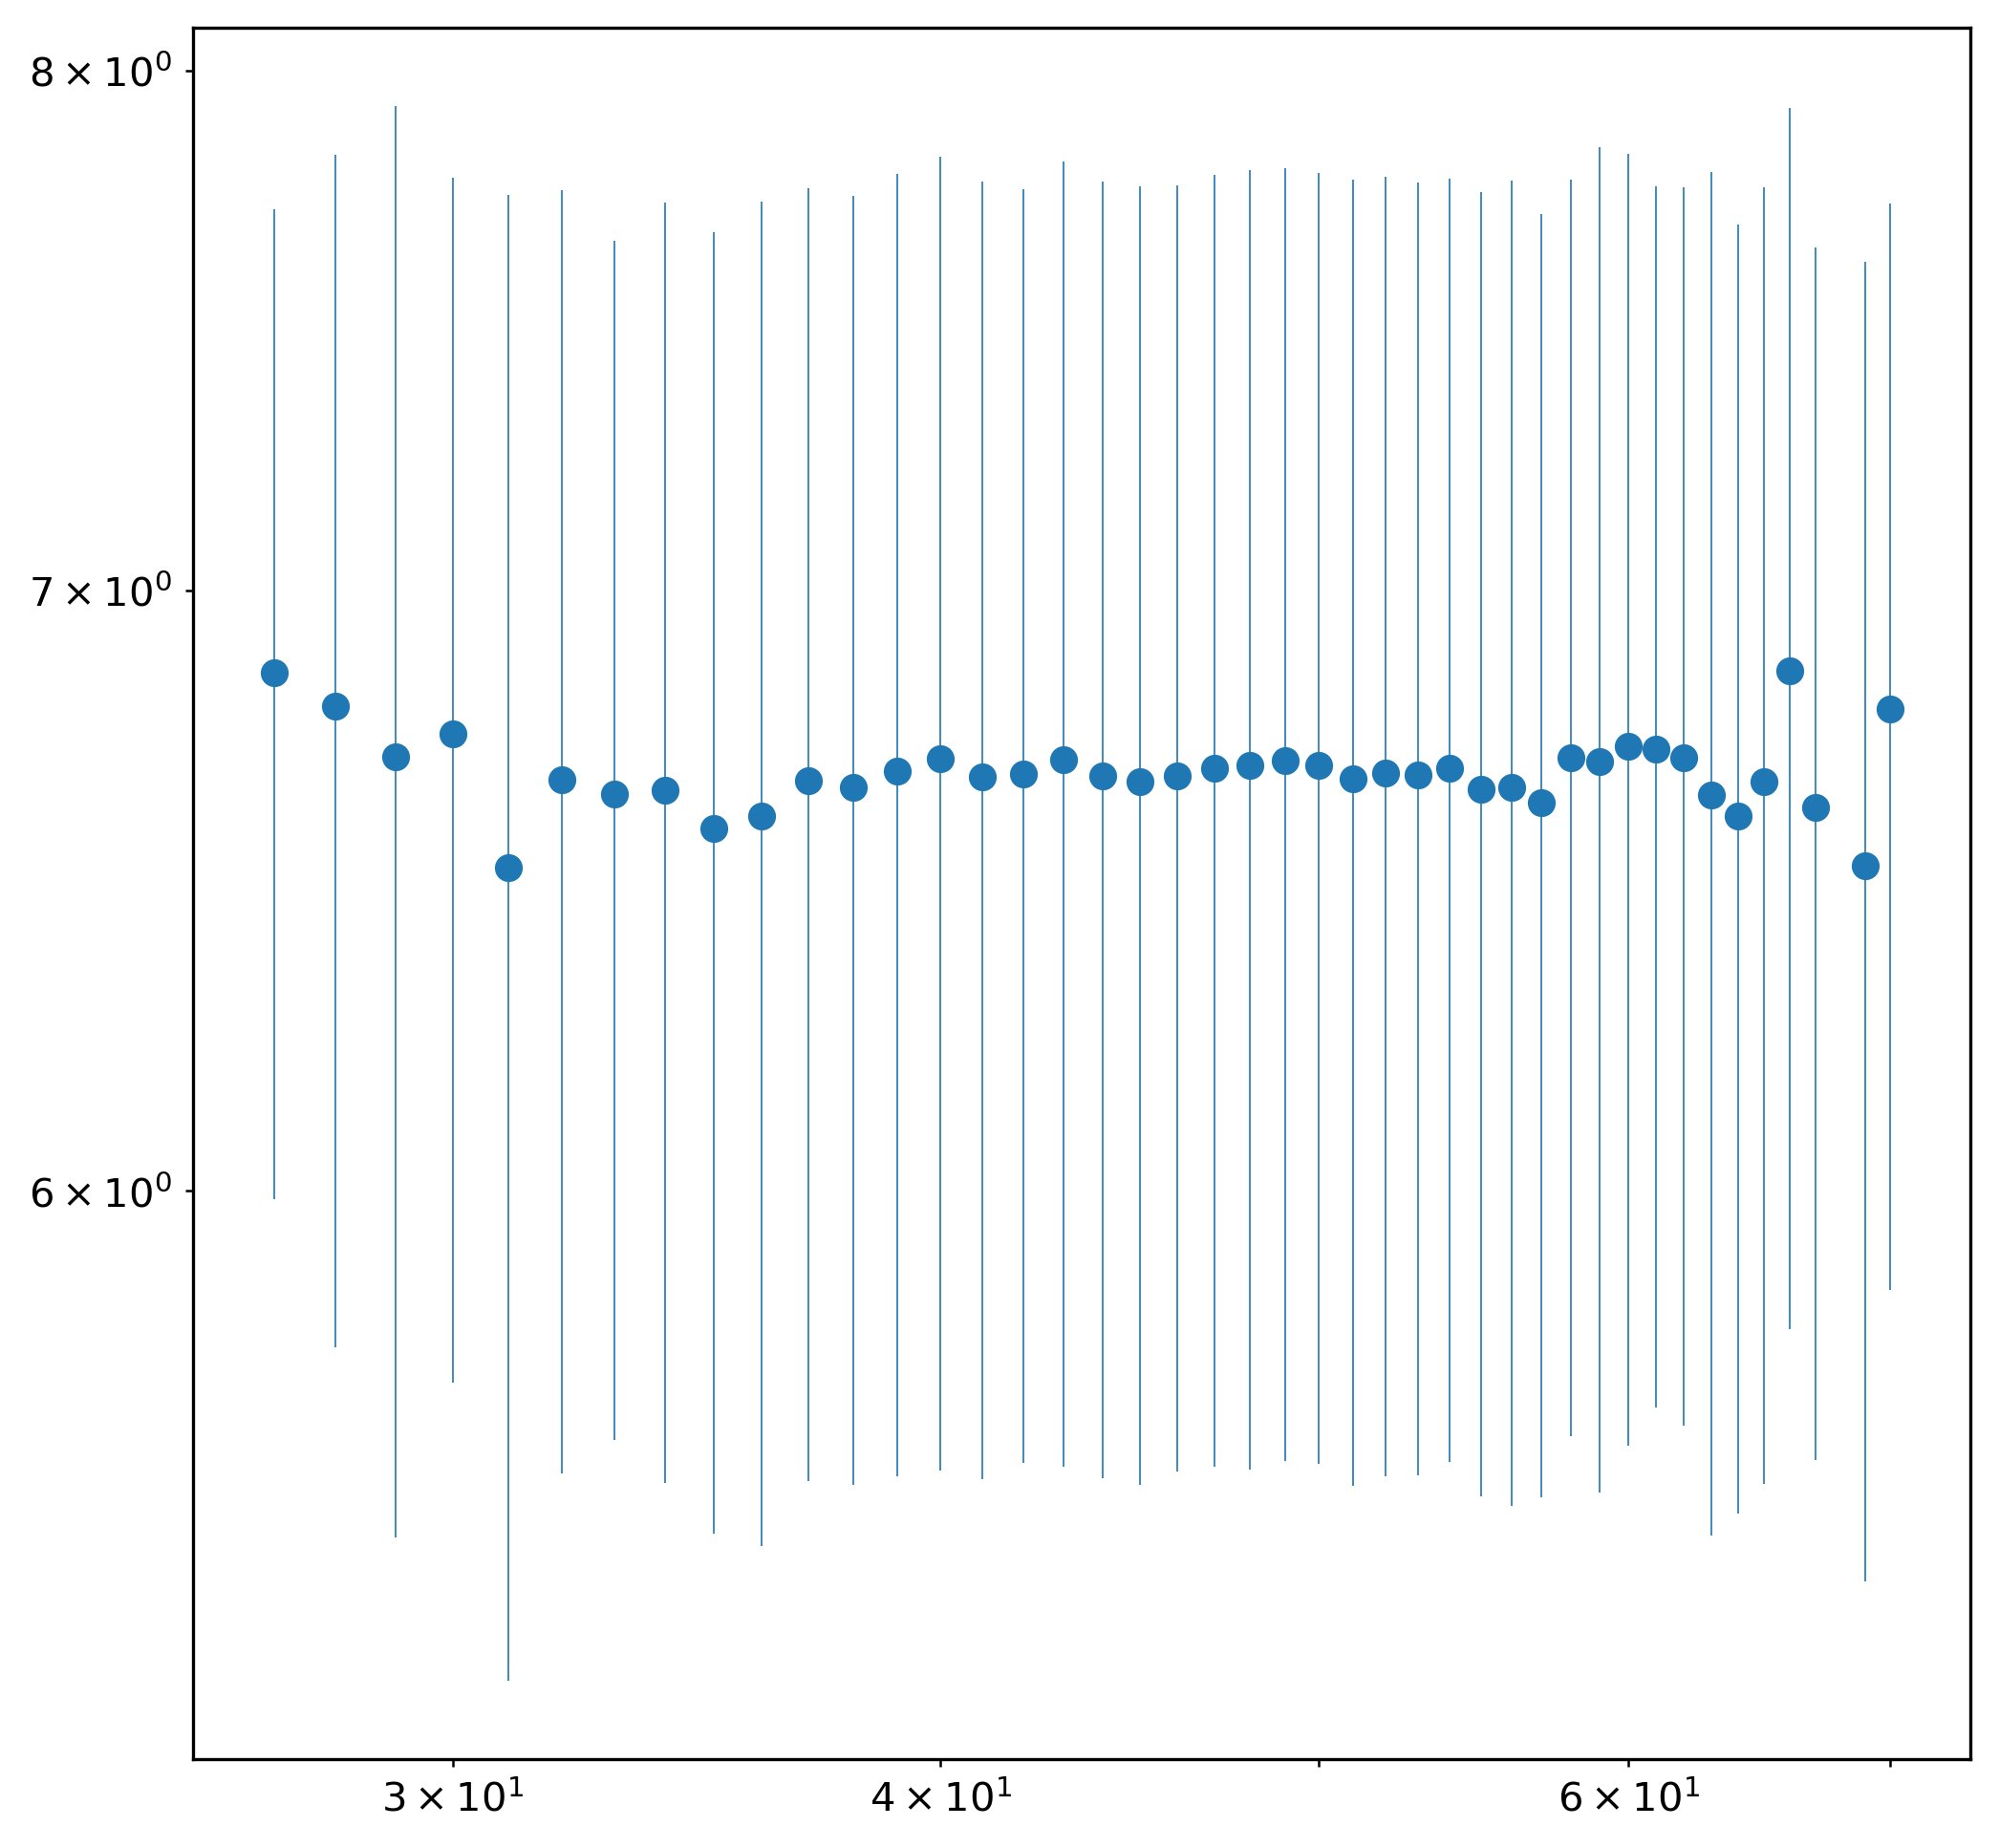

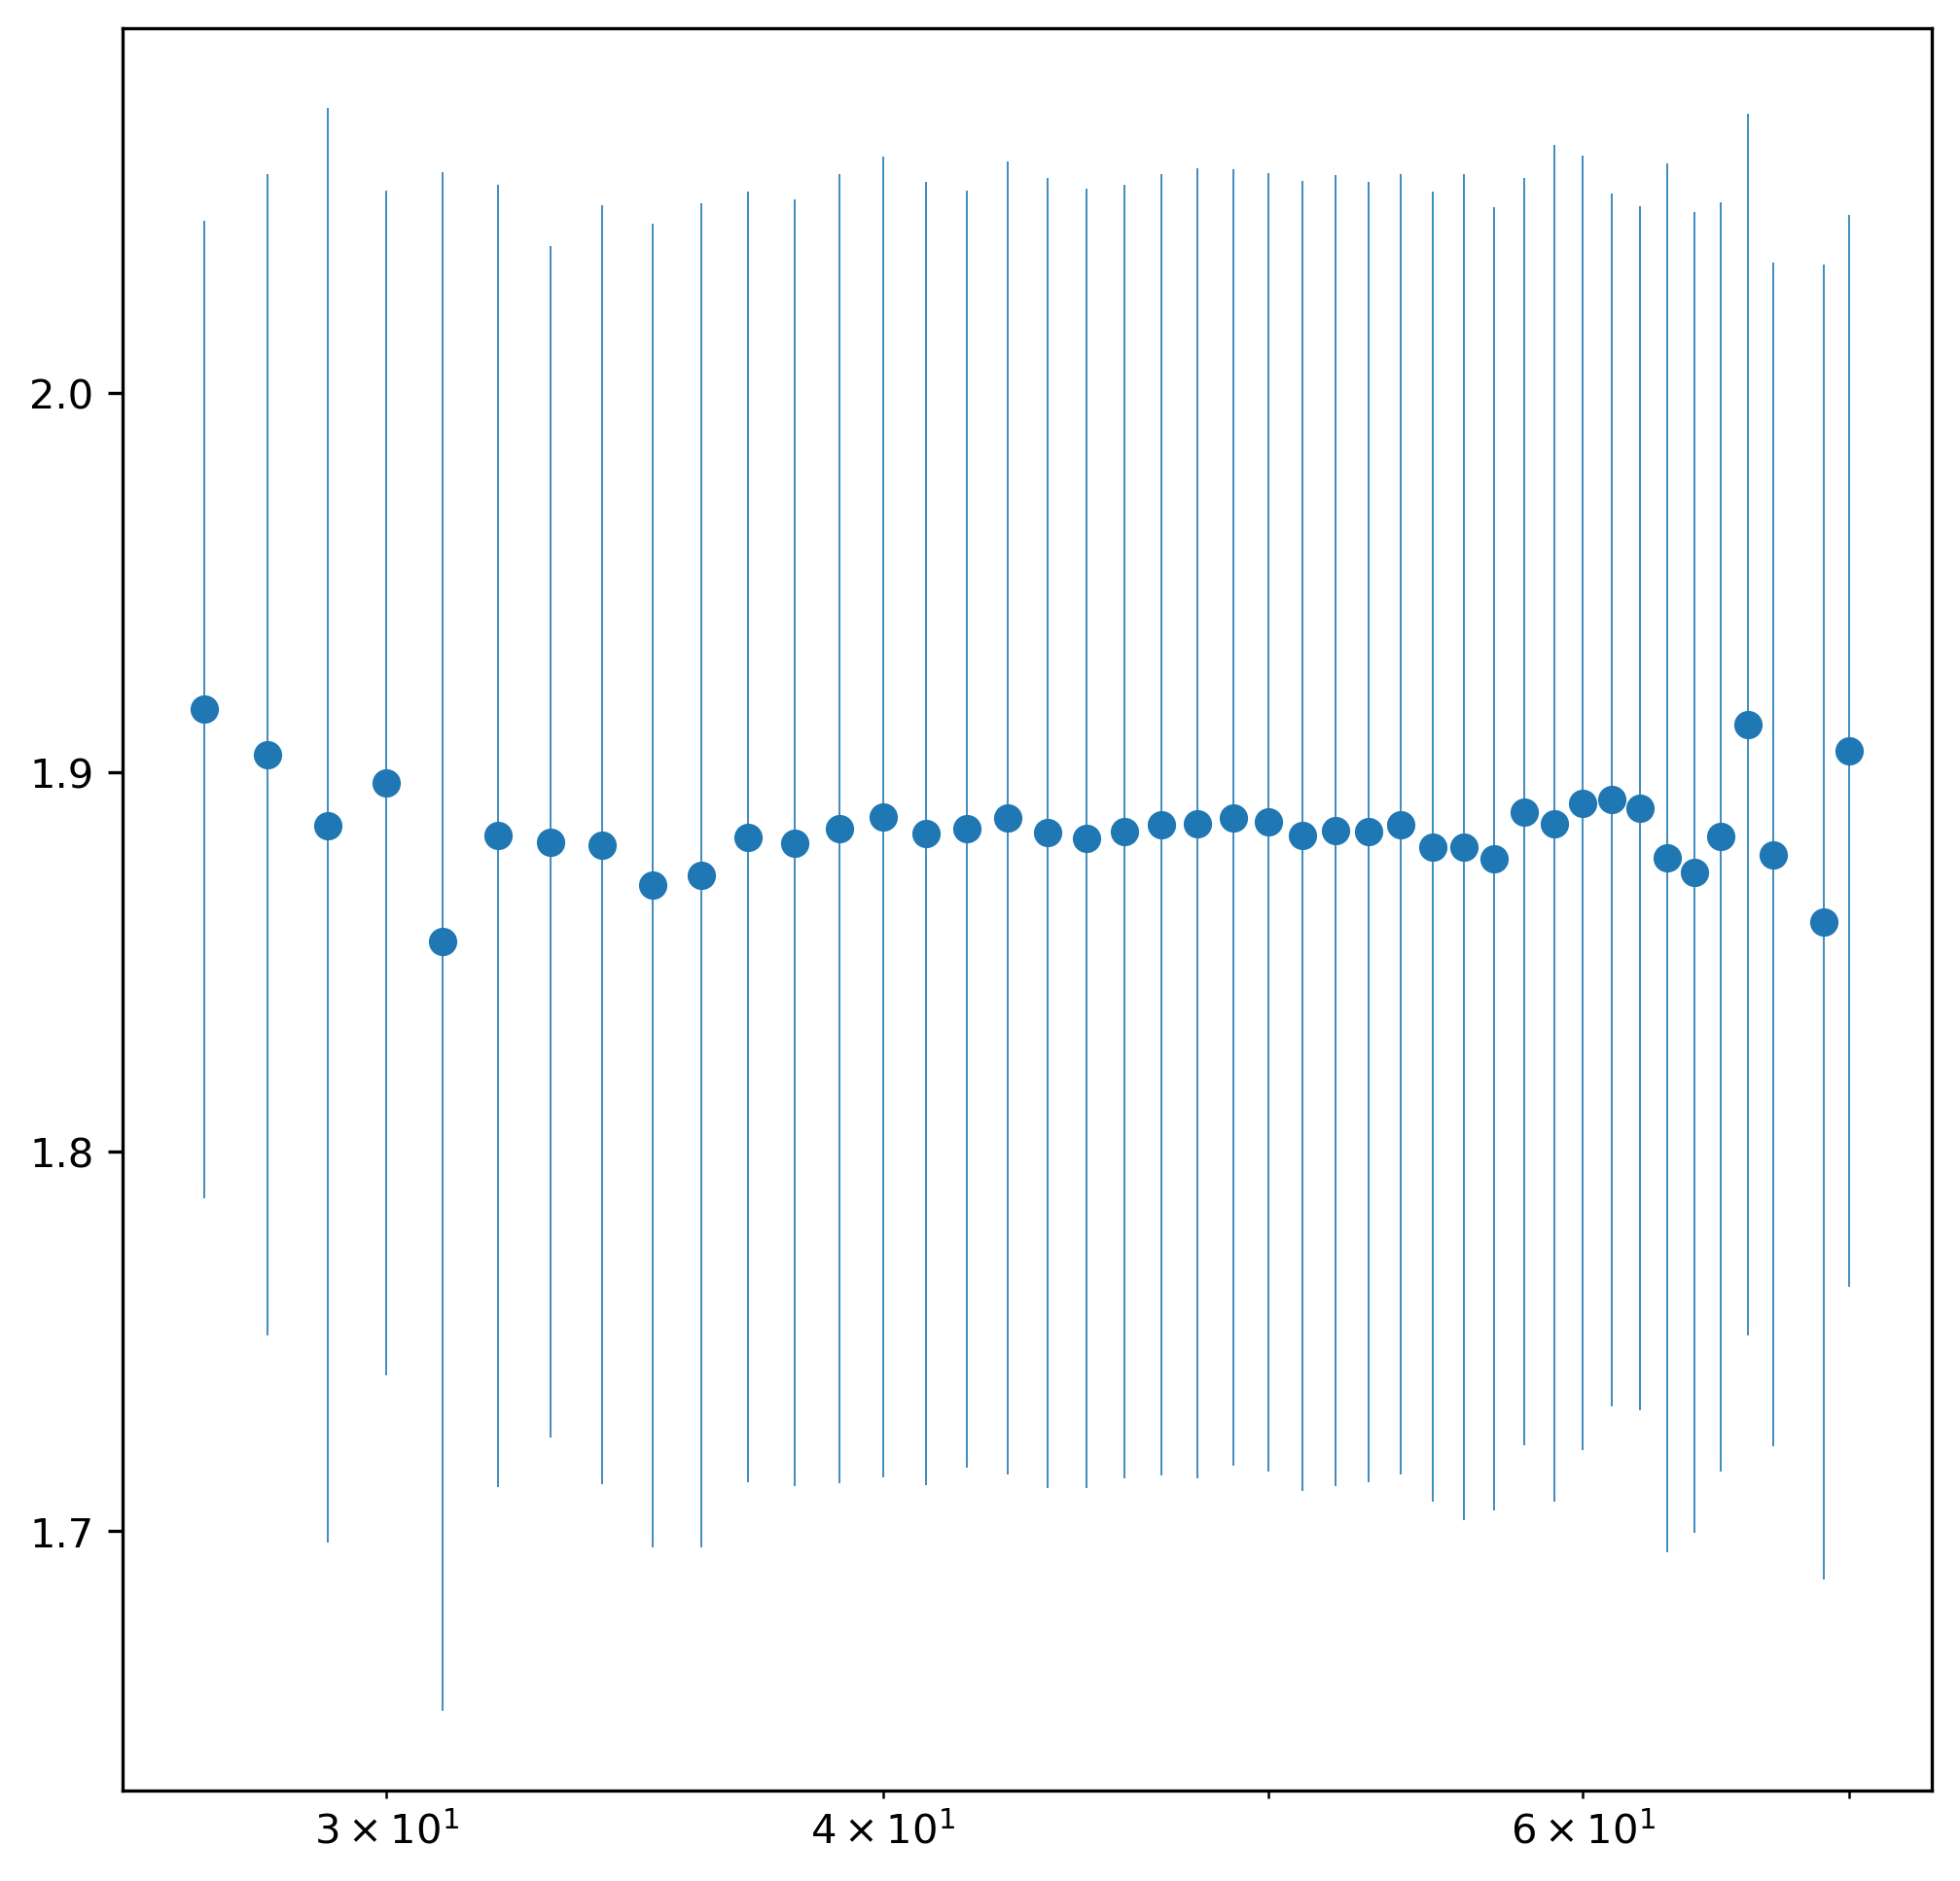

100%|█████████████████████████████████████████████████████████████████████████████| 1507/1507 [00:03<00:00, 473.90it/s]


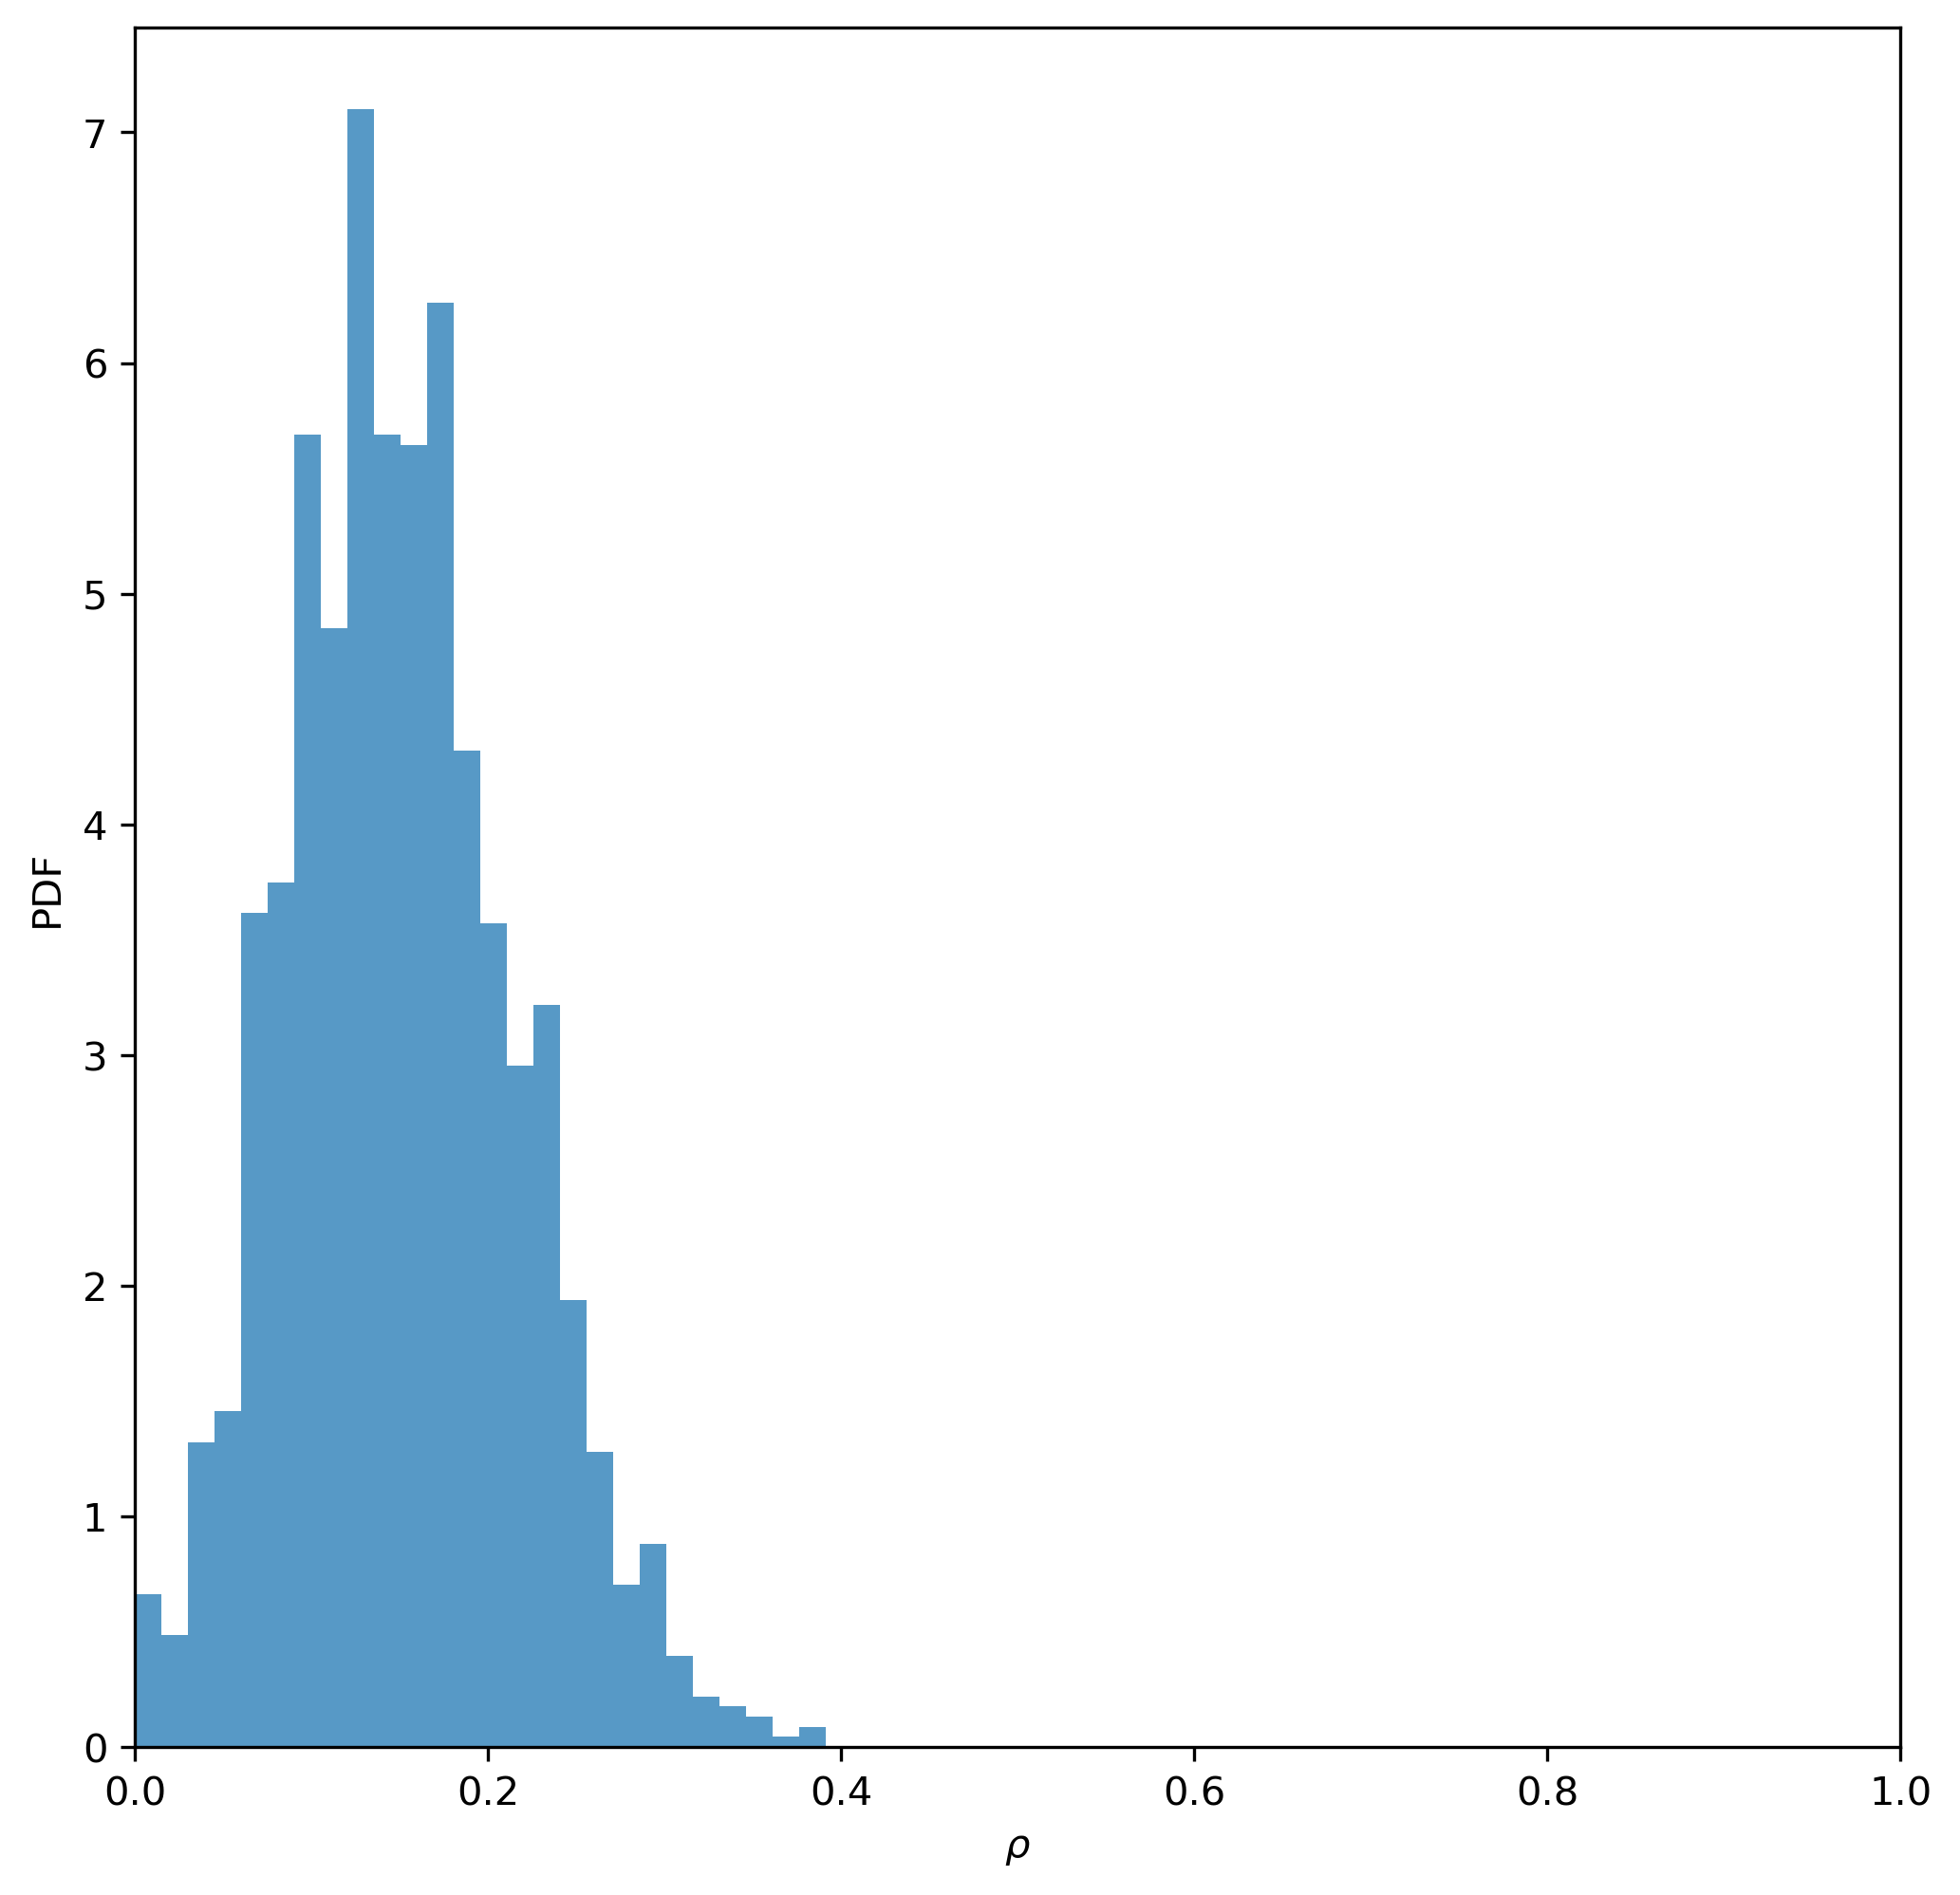

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.15223134799839183


  5%|████▏                                                                         | 543/10000 [01:22<23:50,  6.61it/s]


Loops  544
Error margin:  [9.91139227e-06]


10447it [00:05, 2034.53it/s]


AUC:  0.5107001184966855
AUP:  0.16072785424322364
Transductive performance:
AUC:  0.5107001184966855
AUP:  0.16072785424322364


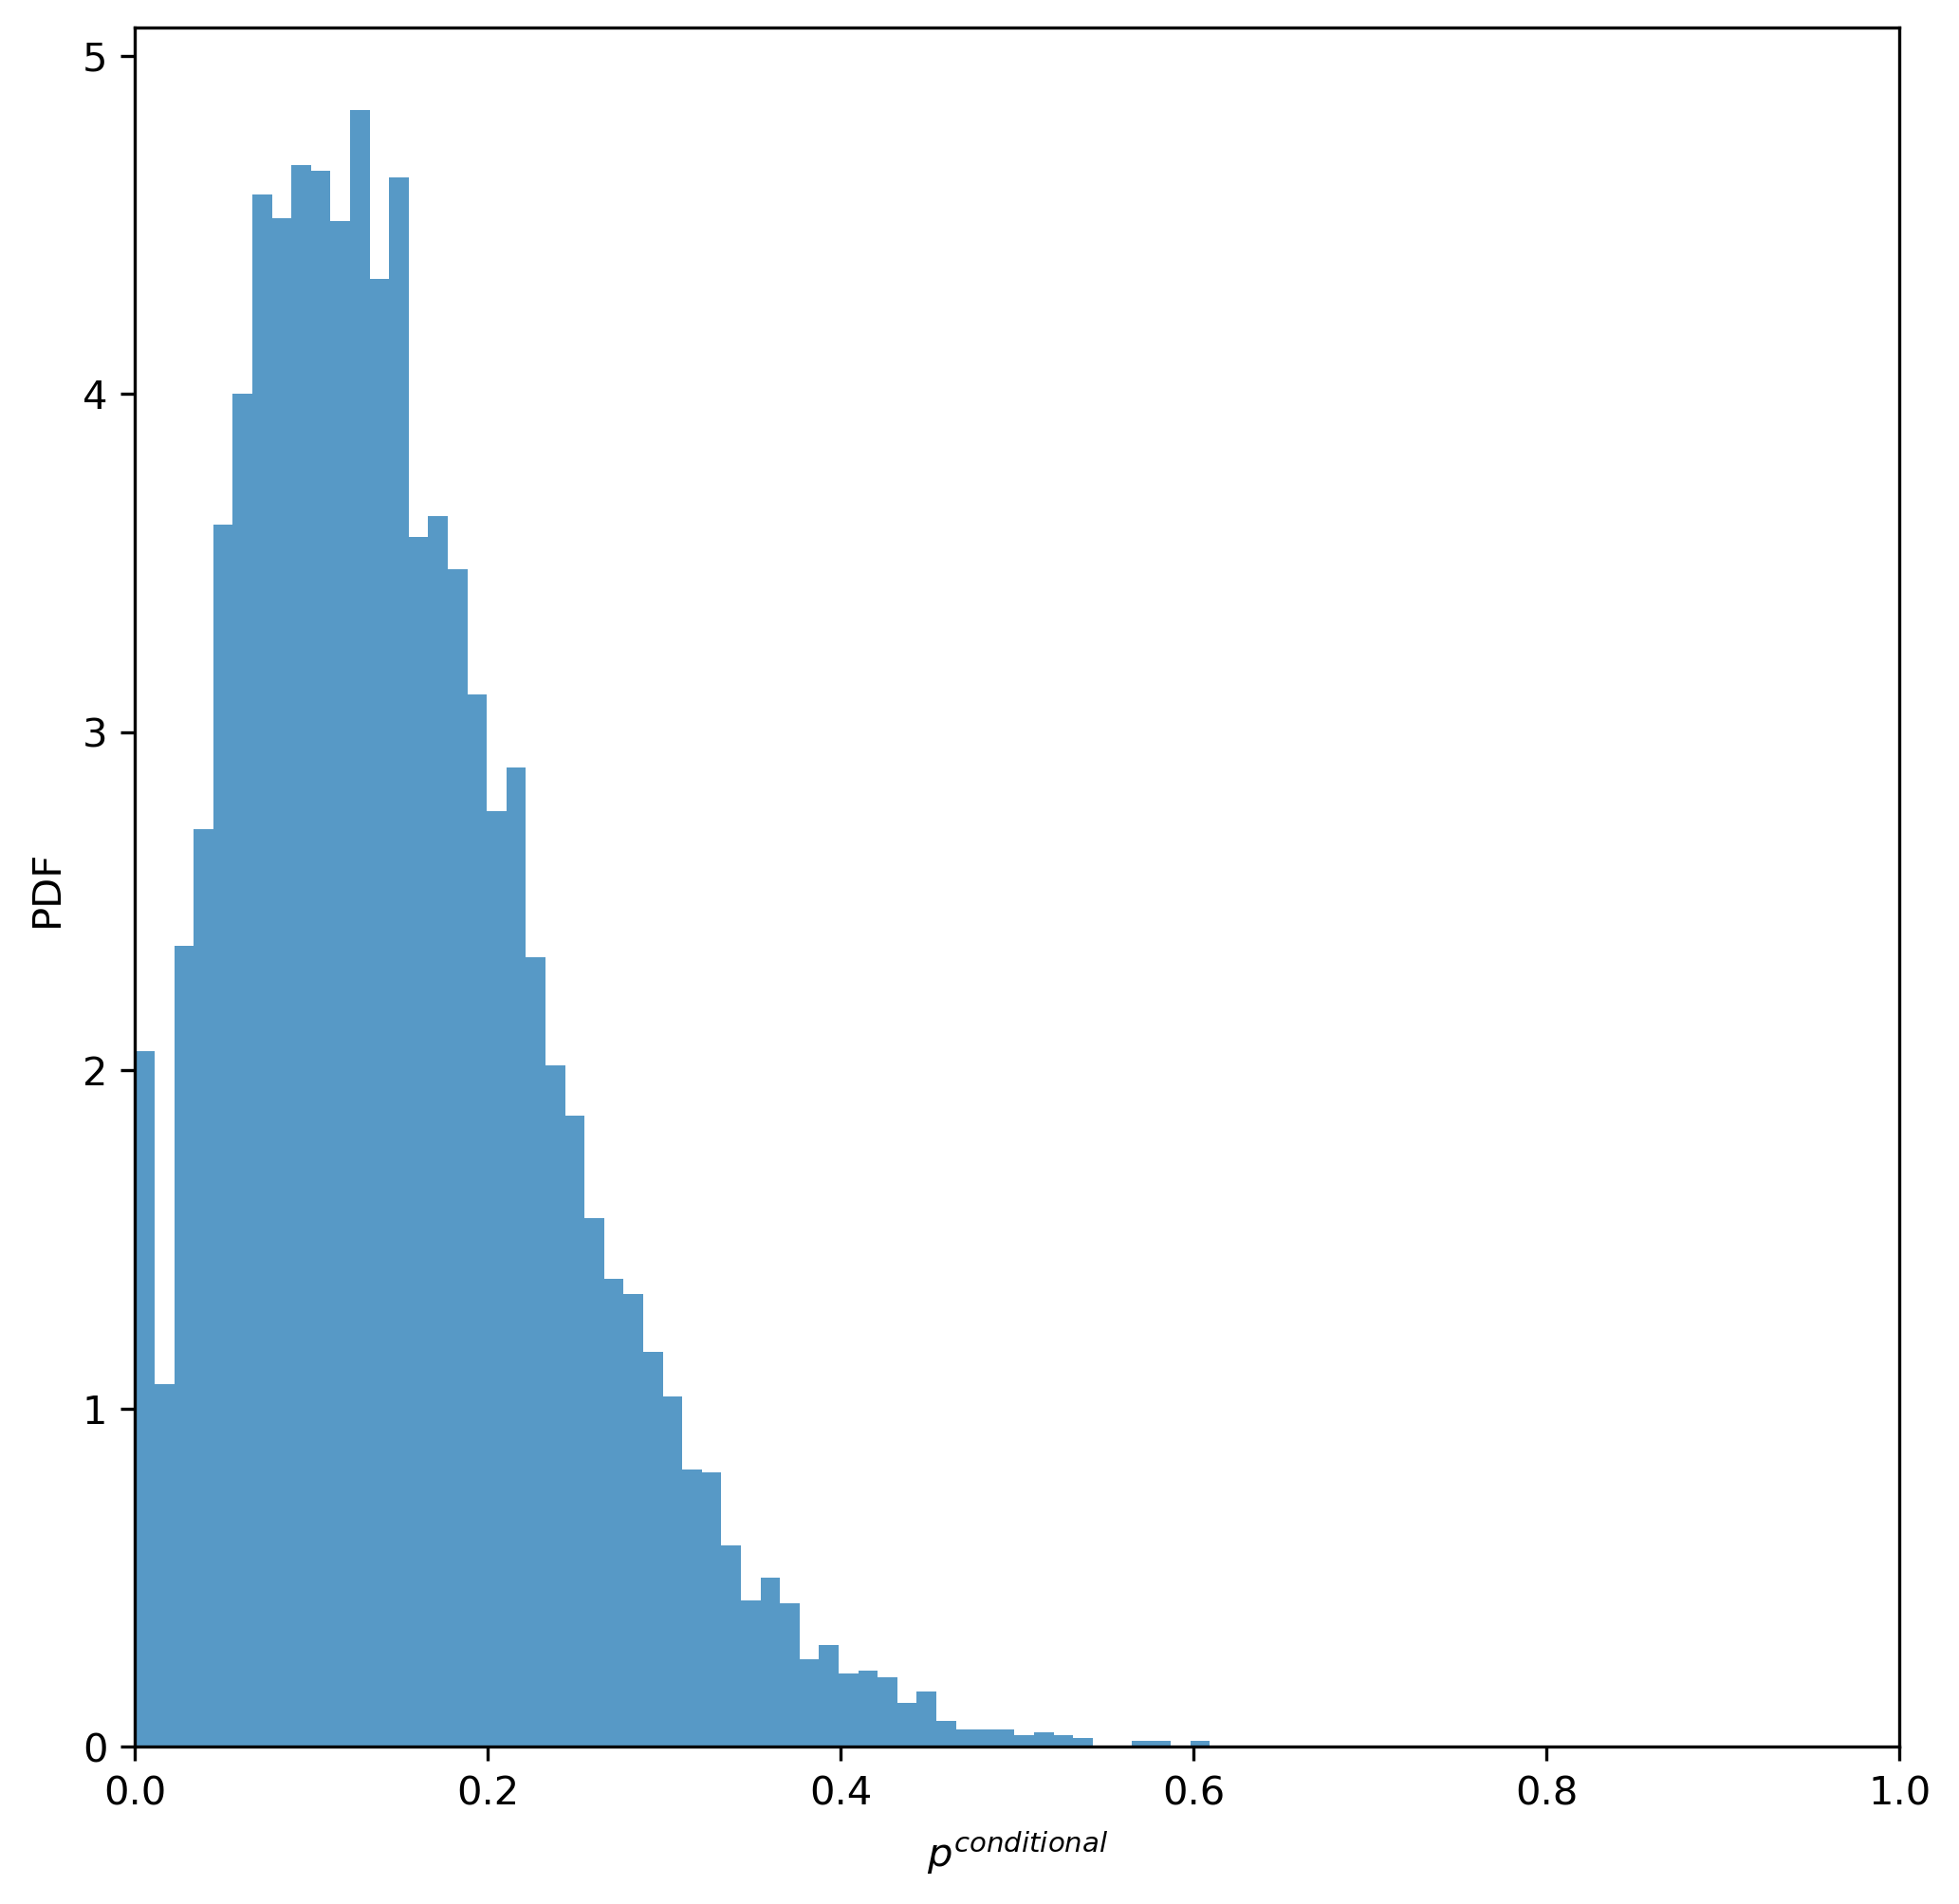

In [63]:
network_dataP_shuffled = remove_correlation_run_configuration_model(network_data_BC_P, precision=10**(-5), loops=10000)